In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3) 가설 및 검증 결과 (고객 리뷰 긍부정 분석)

- #### 가설 : 제품, 배송, 사이트 관련 부정적 초기 경험이 고객 이탈에 영향을 미친다.
- 검증 방식 : 리뷰 긍부정 비교 분석
- 형태소 분석을 기반으로 명사, 형용사 추출 -> '제품', '배송'등 주요 키워드별 n-gram 분석 -> 긍·부정 태깅   -> 부정적 단어 빈도(%) 비교: 이탈 고객 vs 재구매 고객
    - (리뷰 분석 이유) 고객의 온오프라인 경험, 특히 ‘제품’에 대한 고객 경험도 더 깊게 파악하기 위해.



- 세부 가설 및 검증 결과 :

    - [YES] 이탈고객은 재구매 고객보다 제품'품질'에 관한 부정적 단어 언급 빈도율(%) 이 더 높았을 것이다. (오프라인 만족도)
    - [YES] 이탈고객은 재구매 고객보다 제품'마감'에 관한 부정적 단어 언급 빈도율(%) 이 더 높았을 것이다. (오프라인 만족도)
    - [YES] 이탈고객은 재구매 고객보다 '배송'에 관한 부정적 단어 언급 빈도율(%) 이 더 높았을 것이다. (오프라인 만족도)
    - [YES] 이탈고객은 재구매 고객보다 '사이트'에 관한 부정적 단어 언급 빈도율(%) 이 더 높았을 것이다. (오프라인 만족도)
    - [YES] 이탈고객은 재구매 고객보다 사이트'구매'에 관한 부정적 단어 언급 빈도율(%) 이 더 높았을 것이다. (오프라인 만족도)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

import pandas as pd
import numpy as np
import pickle

df_rev = pd.read_csv('/content/drive/MyDrive/리뷰번역_olist_ecommerce_1번구매고객_2017.csv', index_col=0)
df_rev2 = pd.read_csv('/content/drive/MyDrive/리뷰번역_olist_ecommerce_재구매고객_2017.csv', index_col=0)

df_rev = df_rev[df_rev['리뷰내용_한국어번역'].notnull()]
df_rev= df_rev.reset_index(drop=True)

all = pd.concat([df_rev, df_rev2])

<ipython-input-2-9ca953b942db>:10: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_rev = pd.read_csv('/content/drive/MyDrive/리뷰번역_olist_ecommerce_1번구매고객_2017.csv', index_col=0)


In [ ]:

!pip install konlpy
!pip install python-mecab-ko

- . 평점별 리뷰 분석
  - 평점에 따른 리뷰 분석을 위해 텍스트를 전처리하고, 각 평점 그룹의 리뷰 특징을 확인
- (1) 형태소 분석 (전처리) :
  - 리뷰에서 명사, 형용사, 부사를 추출하여 단어 빈도를 분석합니다.
  예를 들어, Mecab을 사용하여 리뷰 텍스트를 분석할 수 있습니다.

In [ ]:
from mecab import MeCab

mecab = MeCab()

# 명사, 형용사, 부사만 추출하는 함수
def extract_keywords(text):
    parsed = mecab.pos(text)
    return [word for word, tag in parsed if tag in ['NNG', 'NNP', 'VA' ]]
# , 'MAG', 'MAJ'
# 리뷰별 키워드 추출
df_rev['keywords_명사_형용사'] = df_rev['리뷰내용_한국어번역'].apply(extract_keywords)
df_rev2['keywords_명사_형용사'] = df_rev2['리뷰내용_한국어번역'].apply(extract_keywords)
all['keywords_명사_형용사'] = all['리뷰내용_한국어번역'].apply(extract_keywords)
# MAG(일반 부사)와 MAJ(접속 부사)


# 명사, 형용사, 부사만 추출하는 함수
def extract_keywords(text):
    parsed = mecab.pos(text)
    return [word for word, tag in parsed if tag in ['NNG', 'NNP', 'VA','MAG' ]]

# 리뷰별 키워드 추출
df_rev['keywords_명사_형용사_부사'] = df_rev['리뷰내용_한국어번역'].apply(extract_keywords)
df_rev2['keywords_명사_형용사_부사'] = df_rev2['리뷰내용_한국어번역'].apply(extract_keywords)
all['keywords_명사_형용사_부사'] = all['리뷰내용_한국어번역'].apply(extract_keywords)

from sklearn.feature_extraction.text import TfidfVectorizer

all['keywords_명사_형용사'] = all['keywords_명사_형용사'].apply(
    lambda x: [word.replace('배달', '배송').replace('구매', '구입') for word in x]
)

df_rev['keywords_명사_형용사'] = df_rev['keywords_명사_형용사'].apply(
    lambda x: [word.replace('배달', '배송').replace('구매', '구입') for word in x]
)

df_rev2['keywords_명사_형용사'] = df_rev2['keywords_명사_형용사'].apply(
    lambda x: [word.replace('배달', '배송').replace('구매', '구입') for word in x]
)

 # df_reviews['keywords_명사_형용사']= df_reviews['keywords_명사_형용사'].str.replace('배달' ,'배송')
 # df_reviews['keywords_명사_형용사']= df_reviews['keywords_명사_형용사'].str.replace('구입' ,'구매')


- (2) 평점별 리뷰 그룹화  & 워드 클라우드 생성
  - 평점별로 리뷰를 그룹화하고, 각 평점에서 자주 등장하는 단어를 시각화하거나 요약할 수 있습니다.
    
    - 형태소 분석: Mecab으로 명사, 형용사, 부사를 추출하여 단어 빈도를 계산.
    - 워드 클라우드 생성: WordCloud 라이브러리로 한국어 텍스트의 시각화.

- (2.1) 전체
- (2.2) 재구매 vs 1번 구매 고객 (첫경험 비교)

- (2.1) 전체 - 평점별 리뷰
  - 평점별로 '제품', '배송',에 대한 얘기가 가장 많고,
  

In [ ]:
# 평점별 리뷰 그룹화
rating_groups = all.groupby('평점')['keywords_명사_형용사'].apply(list)

# 각 평점에서 많이 등장하는 단어 확인
from collections import Counter

rating_keywords = {}
for rating, reviews in rating_groups.items():
    all_keywords = [word for review in reviews for word in review]
    word_freq = Counter(all_keywords)
    rating_keywords[rating] = word_freq.most_common(20)  # 상위 10개 단어 추출

pd.DataFrame(rating_keywords)

### 평점별로 '제품', '배송',에 대한 얘기가 가장 많고,/// (제품 품질에 관한걸까?)
### 그다음은 구입, 도착, 마감,  주문, 품질, 등의 순서로. (<--- 추가!)
### 평점 낮은 애들 -- 사이트에 관한 얘기도..

## 평점 낮을수록 없, 취소, 등의 부정적인 얘기
## 평점 높을수록 좋,  완벽, 추천 등 긍정적 얘기

,1,2,3,4,5
0,"(제품, 2087)","(제품, 530)","(제품, 767)","(제품, 1206)","(제품, 3786)"
1,"(구입, 755)","(배송, 214)","(배송, 312)","(좋, 693)","(좋, 2045)"
2,"(배송, 738)","(구입, 193)","(좋, 282)","(배송, 519)","(배송, 1898)"
3,"(없, 531)","(도착, 109)","(시간, 179)","(도착, 363)","(마감, 1681)"
4,"(도착, 412)","(없, 97)","(구입, 179)","(일, 347)","(일, 1649)"
5,"(지금, 280)","(좋, 86)","(도착, 170)","(마감, 338)","(도착, 1431)"
6,"(주문, 270)","(시간, 86)","(없, 137)","(시간, 316)","(전, 1275)"
7,"(전달, 227)","(주문, 63)","(일, 91)","(구입, 235)","(추천, 1251)"
8,"(요청, 218)","(있, 58)","(있, 89)","(전, 208)","(구입, 837)"
9,"(일, 204)","(일, 57)","(전달, 82)","(추천, 195)","(시간, 836)"


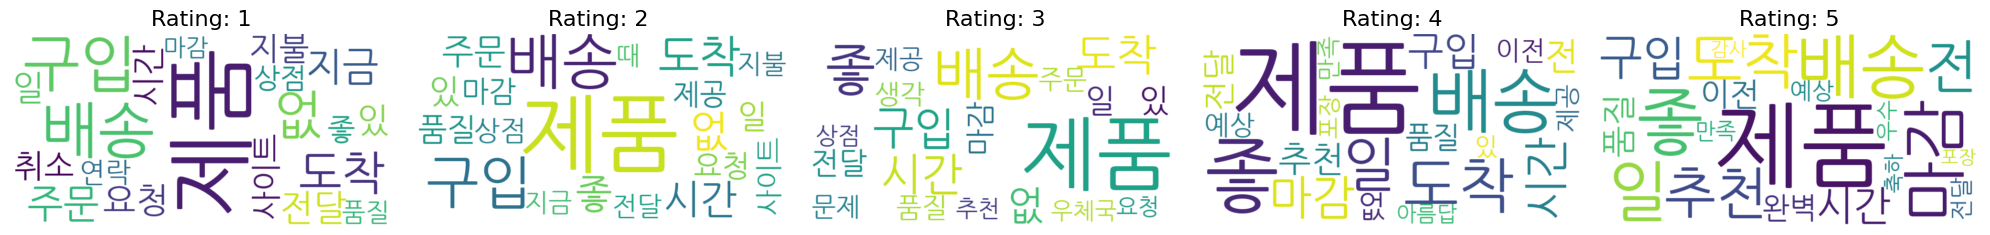

In [ ]:
#!pip install wordcloud matplotlib

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 경로 설정 (다운로드한 나눔고딕 폰트 파일 경로로 설정하세요)
font_path = '/content/drive/MyDrive/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf'  # 나눔고딕 폰트 경로

# 워드클라우드 생성 함수
def create_wordcloud(word_freq, rating, ax):
    wc = WordCloud(font_path=font_path, background_color="white", width=800, height=400).generate_from_frequencies(dict(word_freq))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Rating: {rating}", fontsize=16)

# 평점별로 워드클라우드 그리기
ratings = rating_keywords.keys()  # 평점 리스트 (예: [1, 2, 3, 4, 5])
n_ratings = len(ratings)

# 서브플롯 설정
fig, axs = plt.subplots(1, n_ratings, figsize=(20, 5))  # 1행 n_ratings열로 서브플롯 생성

for i, rating in enumerate(ratings):
    create_wordcloud(rating_keywords[rating], rating, axs[i])

plt.tight_layout()  # 서브플롯 간격 조정
plt.show()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# n-그램 분석: 특정 단어 주변의 연속된 단어를 분석하여 앞뒤에 어떤 단어가 오는지 파악.
# 예시 리뷰 데이터
reviews = [
    "이 제품은 정말 좋았어요",
    "배송이 너무 느렸어요",
    "포장이 깔끔하고 제품이 훌륭합니다",
    "다시는 이용하지 않을 거예요",
    "사용 후기가 좋아서 구매했어요"
]

# 특정 단어 예: '제품'
target_word = '제품'

# n-그램 추출 (여기서는 바이그램 사용)
vectorizer = CountVectorizer(ngram_range=(3, 3))  # 바이그램 (2,2)
X = vectorizer.fit_transform(reviews)

# 바이그램과 빈도수 확인
ngrams = vectorizer.get_feature_names_out()
freqs = X.toarray().sum(axis=0)

# 특정 어휘가 포함된 n-그램 필터링
target_ngrams = [(ngram, freq) for ngram, freq in zip(ngrams, freqs) if target_word in ngram]
print(target_ngrams) # 훌륭합니다, 좋았어요,  깔끔하고

[('깔끔하고 제품이 훌륭합니다', 1), ('제품은 정말 좋았어요', 1), ('포장이 깔끔하고 제품이', 1)]


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# n-그램 분석: 특정 단어 주변의 연속된 단어를 분석하여 앞뒤에 어떤 단어가 오는지 파악.
# 예시 리뷰 데이터
reviews = [
    "이 제품은 정말 좋았어요",
    "배송이 너무 느렸어요",
    "포장이 깔끔하고 제품이 훌륭합니다",
    "다시는 이용하지 않을 거예요",
    "사용 후기가 좋아서 구매했어요"
]
# 특정 단어가 포함된 문장 필터링
keyword = "제품"
filtered_reviews = [review for review in reviews if keyword in review]

# 결과 출력
filtered_reviews

['이 제품은 정말 좋았어요', '포장이 깔끔하고 제품이 훌륭합니다']

In [ ]:
rere = all['리뷰내용_한국어번역'][:1000]

In [ ]:
reviews= list(rere)
keyword = "제품"
filtered_reviews = [review for review in reviews if keyword in review]

# 결과 출력
filtered_reviews

['솔루션을 원합니다. 제품이 많이 필요합니다.',
 '제품은 매우 아름답고 저렴하며 단순하지만 좋은 비용 혜택과 호환됩니다.',
 '의자 뒤쪽의 피팅은 잘못 정렬되었습니다.그는 적합하게 작업하고 마침내 제품을 조립했습니다.',
 '배달은 제 시간에 있었고 판매는 매우 잘 이루어졌습니다.원하는 것을 남긴이 제품의 품질.',
 '오작동과 함께 제공되는 제품, 요청 된 교환.',
 '고품질 제품.',
 '이 제품은 측면 지원없이 왔으며 이미 3 개의 이메일을 보냈으며 지금까지 어떤 직책도받지 못했습니다. 매우 불만족스럽고 조직 부족!',
 '제 시간에 많이 배달, 아주 좋은 제품',
 '나는 2 개의 제품을 구입했고 지금까지 나에게 다른 제품에 대한 답이 없었습니다!',
 '지금까지 제품을받지 못했습니다.',
 '나는 제품을 좋아했고 추천합니다.',
 '제 시간에 전달되는 제품.',
 '2017 년 8 월 22 일에 배송 될 것으로 예상되는 제품을 기다리고 있으며 오늘 08/24/2017은 아직 순간까지 도착하지 않았습니다.',
 '제품이 어느 정도 죄를 잃었습니다',
 '제품은 다른 도시에 있습니다.나는 철회 할 방법이 없습니다.',
 '양질의 제품 제공은 마감일 이전에 매우 만족했습니다.',
 '구매에 따라 매우 시간 엄수 제품이 바로 전달됩니다',
 '제품은 데이트 전에 도착했습니다!',
 '요청 된 제품.',
 '이미 할부금을 지불했지만 아직 제품을받지 못했습니다.나는 Procon에 간다!',
 '간단하고 기능적인 제품.',
 '제품의 포장 또는 제조에주의가 부족했습니다.Targaryen이 아니라 StoreChirars가 올바른 조각을 보내는 공급 업체와 함께 시도합니다.',
 '발표 된 제품.매우 빠른 배송!',
 '마감일 전에 제품이 도착했습니다.',
 '내가 상상했던 것보다 품질이 낮은 제품.그리고 높은 가치.',
 '좋은 품질의 제품, 마감일 이전에 빠른 배송을 권장합니다.',
 '제품은 부러진 조각으로 제대로 포장되어 문제가 해결되지 않았습니다. 

In [ ]:
import re


# '제품'을 포함하고 그 뒤 내용 추출
keyword = "제품"
product_contexts = [re.search(f"({keyword}.*)", review) for review in reviews]
filtered_contexts = [match.group(1).strip() for match in product_contexts if match]

# 결과 출력
filtered_contexts

['제품이 많이 필요합니다.',
 '제품은 매우 아름답고 저렴하며 단순하지만 좋은 비용 혜택과 호환됩니다.',
 '제품을 조립했습니다.',
 '제품의 품질.',
 '제품, 요청 된 교환.',
 '제품.',
 '제품은 측면 지원없이 왔으며 이미 3 개의 이메일을 보냈으며 지금까지 어떤 직책도받지 못했습니다. 매우 불만족스럽고 조직 부족!',
 '제품',
 '제품을 구입했고 지금까지 나에게 다른 제품에 대한 답이 없었습니다!',
 '제품을받지 못했습니다.',
 '제품을 좋아했고 추천합니다.',
 '제품.',
 '제품을 기다리고 있으며 오늘 08/24/2017은 아직 순간까지 도착하지 않았습니다.',
 '제품이 어느 정도 죄를 잃었습니다',
 '제품은 다른 도시에 있습니다.나는 철회 할 방법이 없습니다.',
 '제품 제공은 마감일 이전에 매우 만족했습니다.',
 '제품이 바로 전달됩니다',
 '제품은 데이트 전에 도착했습니다!',
 '제품.',
 '제품을받지 못했습니다.나는 Procon에 간다!',
 '제품.',
 '제품의 포장 또는 제조에주의가 부족했습니다.Targaryen이 아니라 StoreChirars가 올바른 조각을 보내는 공급 업체와 함께 시도합니다.',
 '제품.매우 빠른 배송!',
 '제품이 도착했습니다.',
 '제품.그리고 높은 가치.',
 '제품, 마감일 이전에 빠른 배송을 권장합니다.',
 '제품은 부러진 조각으로 제대로 포장되어 문제가 해결되지 않았습니다. 기다리고 있습니다.',
 '제품은 합의 된 마감일 이전에 배달되었습니다.나는 단 하나의 불만이 있는데, 그들은 내가받은 다른 제품 어셈블리 매뉴얼을 보냈습니다.',
 '제품을 제공 할 시간 이상으로 회사의 문제를 해결하려고 노력하고 누구와도 대화 할 수 없습니다.그들이하는 일은 작동하지 않는 시스템에서 불만을 제기하는 것입니다.',
 '제품이 배달되지 않았습니다.같은 날짜에 함께 구매 한 다른 제품이 이미 접수되었습니다.',
 '제품을 받았다.그러나 나는 귀국을 기다리고있다.나는 제품이 마음에

In [ ]:
# n-그램 추출 (여기서는 바이그램 사용)
vectorizer = CountVectorizer(ngram_range=(2, 2))  # 바이그램 (2,2)
X = vectorizer.fit_transform(filtered_contexts)

# 바이그램과 빈도수 확인
ngrams = vectorizer.get_feature_names_out()
freqs = X.toarray().sum(axis=0)

In [ ]:
ngrams

array(['01 05에 도착할', '01 06의 최대', '01 10까지 이었지만', ..., '흠집 껍질을 벗기고',
       '흥미 롭으므로 키트를', '흰색 덮개를 씌운'], dtype=object)

In [ ]:
# 특정 어휘가 포함된 n-그램 필터링
target_ngrams = [(ngram, freq) for ngram, freq in zip(ngrams, freqs)  ]
target_ngrams

[('01 05에', 1),
 ('01 06의', 2),
 ('01 10까지', 1),
 ('01 2018', 1),
 ('01 받았습니다', 2),
 ('05에 도착할', 1),
 ('06의 최대', 2),
 ('08 01', 1),
 ('08 24', 1),
 ('09 26의', 1),
 ('09에 도착했습니다', 1),
 ('10까지 이었지만', 1),
 ('11에 도착했고', 1),
 ('12 27', 1),
 ('12 영업일', 1),
 ('12 월에', 2),
 ('12 일에', 1),
 ('12에 도달하는', 1),
 ('12이며 아무것도', 1),
 ('13 09에', 1),
 ('14 12에', 1),
 ('15 일의', 1),
 ('16 일이며', 1),
 ('18 12이며', 1),
 ('2017 12', 1),
 ('2017은 아직', 1),
 ('2018 att에서', 1),
 ('24 2017은', 1),
 ('25 11에', 1),
 ('26의 배달', 1),
 ('27 일까지', 1),
 ('28 일에', 1),
 ('2kg을 샀고', 1),
 ('300g는 아직', 1),
 ('3kg 유청을', 1),
 ('50ml 보충제가', 1),
 ('5를 샀고', 1),
 ('64cm라는 의견이', 1),
 ('att에서 돌아온다', 1),
 ('bca drink', 1),
 ('bca max를', 1),
 ('cnpj를 찾고', 1),
 ('com에서 주문합니다', 1),
 ('coracker는 마감일', 1),
 ('dhea 50ml', 1),
 ('donald s의', 1),
 ('drink liquid가', 1),
 ('flamengo로부터 개의', 1),
 ('goodwill에서 매우', 1),
 ('impressional에 대해', 1),
 ('lanister는 판매하기', 1),
 ('lannister com에서', 1),
 ('lannister supplement는', 1),
 ('lannister가 설정', 1),
 ('l

### n-그램 개념 / 예시

In [ ]:

### n-그램 개념 / 예시
'''
from sklearn.feature_extraction.text import CountVectorizer
# n-그램 분석: 특정 단어 주변의 연속된 단어를 분석하여 앞뒤에 어떤 단어가 오는지 파악.
# 예시 리뷰 데이터
reviews = [
    "이 제품은 정말 좋았어요",
    "배송이 너무 느렸어요",
    "포장이 깔끔하고 제품이 훌륭합니다",
    "다시는 이용하지 않을 거예요",
    "사용 후기가 좋아서 구매했어요"
]

# 특정 단어 예: '제품'
target_word = '제품'

# n-그램 추출 (여기서는 바이그램 사용)
vectorizer = CountVectorizer(ngram_range=(2, 2))  # 바이그램
X = vectorizer.fit_transform(reviews)

# 바이그램과 빈도수 확인
ngrams = vectorizer.get_feature_names_out()
freqs = X.toarray().sum(axis=0)

# 특정 어휘가 포함된 n-그램 필터링
target_ngrams = [(ngram, freq) for ngram, freq in zip(ngrams, freqs) if target_word in ngram]
print(target_ngrams)
'''

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
import pandas as pd


# 명사만 추출하는 함수
def extract_keywords_3(text):
    parsed = mecab.pos(text)
    return [word for word, tag in parsed if tag in [ 'NNG', 'NNP'  ]] # ,'MAG'부사 , /// 'NNG', 'NNP', 이들은 명사

# 형용사만 추출하는 함수
def extract_keywords_1(text):
    parsed = mecab.pos(text)
    return [word for word, tag in parsed if tag in [ 'VA'  ]] # ,'MAG'부사 , /// 'NNG', 'NNP', 이들은 명사

def make_df_reviews(data, keyword):
  df_reviews = pd.DataFrame()
  # 평점별 리뷰를 그룹화
  for i in range(1, 6):
    grouped_reviews = data.groupby('평점')['리뷰내용_한국어번역'].apply(lambda reviews: ' '.join(reviews)).reset_index()
    reviews = list(data[data['평점'] ==i]['리뷰내용_한국어번역'])

    # 특정 단어 예: '제품'
    target_word = keyword # '제품'

    # n-그램 추출 (여기서는 바이그램 사용)
    vectorizer = CountVectorizer(ngram_range=(3,3))  # 3-gram
    X = vectorizer.fit_transform(reviews)

    # 바이그램과 빈도수 확인
    ngrams = vectorizer.get_feature_names_out()
    freqs = X.toarray().sum(axis=0)

    # 특정 어휘가 포함된 n-그램 필터링
    target_ngrams = [(ngram, freq) for ngram, freq in zip(ngrams, freqs) if target_word in ngram]
     # 빈도율 계산
     #######
    total_count = sum(freqs)  # 평점별 전체 빈도수
    target_ngrams_with_rate = [(ngram, freq / total_count) for ngram, freq in target_ngrams]

    df_reviewsss = pd.DataFrame(list(target_ngrams), columns=['리뷰', '빈도수'])
    df_reviewsss['평점'] = i

    df_reviews = pd.concat([df_reviews,df_reviewsss ])
  return df_reviews



##  평점별 키워드 n-gram 비교 : 이탈 고객  vs 재구매 고객

###  1) 평점별 비교 : '제품' 키워드


In [ ]:
### 평점별로 '제품', '배송',에 대한 얘기가 가장 많고,/// (제품 품질에 관한걸까?)
### 그다음은 구입, 도착, 마감,   품질, 사이트 등의 순서로.
### 평점 낮은 애들 -- 사이트에 관한 얘기도..

In [ ]:
## 제품, 배송, 도착, 구입, 마감, 품질, 사이트

### flow check

- 키워드 별 n-gram. -> 빈도 (%) 비교
- 즉, 특정 [키워드] : 이탈 고객 vs 재구매 고객 평점별 n-gram -> 빈도 (%) 비교

- 가설 ::

In [ ]:
def make_result(data, keyword__, extract_keywords):
  keyword = keyword__ #'제품'
  df_reviews = make_df_reviews(data, keyword)

  # 리뷰별 키워드 추출 : 명사, --- extract_keywords_3
  df_reviews['keywords_명사_형용사'] = df_reviews['리뷰'].apply(extract_keywords)

  # 리스트 형태를 문자열로 변환하는 함수 적용
  df_reviews['keywords_명사_형용사']= df_reviews['keywords_명사_형용사'].apply(lambda x: ', '.join(x))

  df_reviews['keywords_명사_형용사']= df_reviews['keywords_명사_형용사'].str.replace(keyword, '')

  import pandas as pd
  from sklearn.feature_extraction.text import TfidfVectorizer

  grouped = df_reviews.groupby('평점')['keywords_명사_형용사'].apply(lambda x: ' '.join(x))

  df11 = grouped.copy()
  df11 = df11.reset_index()

  ### 명사

  for i in range(0,5):
    result = ', '.join(df11['keywords_명사_형용사'][i].split())
    cleaned_words = [word.strip() for word in result.split(",") if word.strip()]
    cleaned_text = ", ".join(cleaned_words)
    df11['keywords_명사_형용사'][i] = cleaned_text

  ## 형용사, 명사

  import pandas as pd
  from collections import Counter

  # 평점별로 단어 분리 및 빈도율 계산
  result = {}

  for idx, row in df11.iterrows():
      rating = row['평점']
      words = row['keywords_명사_형용사'].replace(" ", "").split(",")  # 공백 제거 후 ',' 기준으로 분리
      total_words = len(words)  # 총 단어 수
      word_counts = Counter(words)  # 단어 빈도 계산
      word_frequencies = {word: count / total_words for word, count in word_counts.items()}  # 빈도율 계산

      # 빈도율 기준으로 상위 10개 추출
      top_10_frequencies = dict(sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:20])
      result[rating] = top_10_frequencies
  return result


In [ ]:

##  명사  extract_keywords_3
keyword00 = '제품'
result = make_result(df_rev, keyword00, extract_keywords_3)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 명사 / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('제품' 키워드 관련 /   명사 / 빈도율(%)기준):
  구입: 6.72%
  배달: 3.19%
  구매: 3.11%
  도착: 3.08%
  전달: 2.11%
  지불: 1.94%
  개: 1.69%
  제공: 1.69%
  배송: 1.67%
  지금: 1.58%
  품질: 1.36%
  일: 1.33%
  상점: 1.28%
  시간: 1.25%
  결함: 1.22%
  품의: 1.11%
  취소: 1.05%
  사이트: 1.03%
  요청: 1.03%
  주문: 1.00%


평점 2의 상위 20개 단어 ('제품' 키워드 관련 /   명사 / 빈도율(%)기준):
  구입: 4.77%
  도착: 3.78%
  배달: 3.42%
  구매: 2.70%
  개: 2.43%
  제공: 2.16%
  품질: 2.07%
  품의: 1.53%
  시간: 1.53%
  추천: 1.44%
  전달: 1.44%
  전: 1.35%
  요청: 1.35%
  상점: 1.35%
  사이트: 1.26%
  사진: 1.17%
  지불: 1.17%
  일: 1.08%
  교환: 0.99%
  의: 0.99%


평점 3의 상위 20개 단어 ('제품' 키워드 관련 /   명사 / 빈도율(%)기준):
  도착: 3.58%
  배달: 3.16%
  시간: 2.81%
  구입: 2.59%
  품질: 2.52%
  배송: 2.10%
  구매: 1.82%
  전달: 1.75%
  개: 1.54%
  품의: 1.47%
  일: 1.40%
  제공: 1.33%
  마감: 1.33%
  사진: 1.12%
  상점: 1.12%
  화물: 1.05%
  포장: 1.05%
  전: 0.98%
  우체국: 0.91%
  손상: 0.91%


평점 4의 상위 20개 단어 ('제품' 키워드 관련 /   명사 / 빈도율(%)기준):
  시간: 4.20%
  배달: 4.02%
  도착: 3.88%
  품질: 3.37%
  일: 3.05%
  마감: 2.95%
  배송: 2.95%
 

<ipython-input-7-b7301b05b819>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-7-b7301b05b819>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
df_rev[df_rev['평점'] ==1].index

Index([    0,    10,    14,    16,    17,    24,    31,    33,    43,    46,
       ...
       16784, 16797, 16801, 16812, 16814, 16821, 16822, 16824, 16828, 16832],
      dtype='int64', length=3229)

In [ ]:


# 리뷰별 키워드 추출 : 명사, --- extract_keywords_3
df_reviews['keywords_명사_형용사'] = df_reviews['리뷰'].apply(extract_keywords)

# 리스트 형태를 문자열로 변환하는 함수 적용
df_reviews['keywords_명사_형용사']= df_reviews['keywords_명사_형용사'].apply(lambda x: ', '.join(x))

df_reviews['keywords_명사_형용사']= df_reviews['keywords_명사_형용사'].str.replace(keyword, '')

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

grouped = df_reviews.groupby('평점')['keywords_명사_형용사'].apply(lambda x: ' '.join(x))

df11 = grouped.copy()
df11 = df11.reset_index()

### 명사

for i in range(0,5):
  result = ', '.join(df11['keywords_명사_형용사'][i].split())
  cleaned_words = [word.strip() for word in result.split(",") if word.strip()]
  cleaned_text = ", ".join(cleaned_words)
  df11['keywords_명사_형용사'][i] = cleaned_text

## 형용사, 명사

import pandas as pd
from collections import Counter

# 평점별로 단어 분리 및 빈도율 계산
result = {}

for idx, row in df11.iterrows():
    rating = row['평점']
    words = row['keywords_명사_형용사'].replace(" ", "").split(",")  # 공백 제거 후 ',' 기준으로 분리
    total_words = len(words)  # 총 단어 수
    word_counts = Counter(words)  # 단어 빈도 계산
    word_frequencies = {word: count / total_words for word, count in word_counts.items()}  # 빈도율 계산

    # 빈도율 기준으로 상위 10개 추출
    top_10_frequencies = dict(sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:20])
    result[rating] = top_10_frequencies

<ipython-input-78-47c6a8f05e11>:27: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<ipython-input-78-47c6a8f05e11>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

{1: {'없': 0.3352941176470588,
  '있': 0.2235294117647059,
  '좋': 0.1,
  '많': 0.04411764705882353,
  '같': 0.041176470588235294,
  '낮': 0.03823529411764706,
  '다르': 0.029411764705882353,
  '수없': 0.020588235294117647,
  '늦': 0.01764705882352941,
  '검': 0.014705882352941176,
  '올바르': 0.014705882352941176,
  '작': 0.011764705882352941,
  '적': 0.011764705882352941,
  '비싸': 0.008823529411764706,
  '나쁘': 0.008823529411764706,
  '얇': 0.0058823529411764705,
  '괜찮': 0.0058823529411764705,
  '쓸모없': 0.0058823529411764705,
  '어떻': 0.0058823529411764705,
  '가볍': 0.0058823529411764705},
 2: {'좋': 0.23333333333333334,
  '있': 0.2,
  '없': 0.16666666666666666,
  '같': 0.075,
  '많': 0.05,
  '비싸': 0.041666666666666664,
  '낮': 0.03333333333333333,
  '다르': 0.03333333333333333,
  '작': 0.025,
  '올바르': 0.025,
  '어떻': 0.025,
  '나': 0.016666666666666666,
  '검': 0.016666666666666666,
  '놀랍': 0.016666666666666666,
  '아름답': 0.008333333333333333,
  '더럽': 0.008333333333333333,
  '늦': 0.008333333333333333,
  '어렵': 0.008333

In [ ]:

## 형용사  extract_keywords_1
keyword00 = '제품'
result = make_result(df_rev, keyword00, extract_keywords_1)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 형용사 only / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('제품' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  없: 33.53%
  있: 22.35%
  좋: 10.00%
  많: 4.41%
  같: 4.12%
  낮: 3.82%
  다르: 2.94%
  수없: 2.06%
  늦: 1.76%
  검: 1.47%
  올바르: 1.47%
  작: 1.18%
  적: 1.18%
  비싸: 0.88%
  나쁘: 0.88%
  얇: 0.59%
  괜찮: 0.59%
  쓸모없: 0.59%
  어떻: 0.59%
  가볍: 0.59%


평점 2의 상위 20개 단어 ('제품' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 23.33%
  있: 20.00%
  없: 16.67%
  같: 7.50%
  많: 5.00%
  비싸: 4.17%
  낮: 3.33%
  다르: 3.33%
  작: 2.50%
  올바르: 2.50%
  어떻: 2.50%
  나: 1.67%
  검: 1.67%
  놀랍: 1.67%
  아름답: 0.83%
  더럽: 0.83%
  늦: 0.83%
  어렵: 0.83%
  빠르: 0.83%


평점 3의 상위 20개 단어 ('제품' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 32.50%
  있: 11.50%
  없: 8.00%
  같: 5.50%
  작: 5.50%
  낮: 5.00%
  많: 5.00%
  올바르: 4.00%
  나쁘: 3.50%
  빠르: 3.00%
  아름답: 2.50%
  크: 2.00%
  괜찮: 1.50%
  비싸: 1.50%
  나: 1.00%
  느리: 1.00%
  검: 1.00%
  늦: 1.00%
  심하: 1.00%
  강하: 1.00%


평점 4의 상위 20개 단어 ('제품' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 51.17%
  아름답: 7.36%
  있: 6.35%
  올바르: 6.02%
  없: 5.02%
  빠르: 4.35%
  같: 2.68%
  많: 2.34

<ipython-input-64-6ae0ed89144a>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-64-6ae0ed89144a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [ ]:

##  명사  extract_keywords_3
keyword00 = '제품'
result = make_result(df_rev2, keyword00, extract_keywords_3)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 명사 / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('제품' 키워드 관련 / 명사 / 빈도율(%)기준):
  배달: 4.57%
  구매: 3.43%
  결함: 3.43%
  개: 2.86%
  구입: 2.86%
  제공: 2.86%
  지불: 2.86%
  사이트: 2.29%
  도착: 2.29%
  전달: 2.29%
  품의: 2.29%
  광고: 1.71%
  냄비: 1.71%
  요청: 1.71%
  평가: 1.71%
  상점: 1.71%
  취소: 1.71%
  가능: 1.14%
  가소: 1.14%
  동등: 1.14%


평점 2의 상위 20개 단어 ('제품' 키워드 관련 / 명사 / 빈도율(%)기준):
  유일: 8.33%
  나열: 5.56%
  의이: 5.56%
  구입: 5.56%
  장치: 5.56%
  배달: 5.56%
  사이트: 5.56%
  사진: 5.56%
  설명: 5.56%
  필수품: 5.56%
  상점: 5.56%
  가격: 2.78%
  상상: 2.78%
  발표: 2.78%
  항목: 2.78%
  구매: 2.78%
  마감: 2.78%
  일: 2.78%
  하루: 2.78%
  일치: 2.78%


평점 3의 상위 20개 단어 ('제품' 키워드 관련 / 명사 / 빈도율(%)기준):
  시간: 9.33%
  도착: 5.33%
  배송: 5.33%
  이전: 4.00%
  후회: 4.00%
  오른쪽: 2.67%
  송장: 2.67%
  합리: 2.67%
  최고: 2.67%
  안: 2.67%
  품의: 2.67%
  오늘: 2.67%
  우수: 2.67%
  품질: 2.67%
  수신: 2.67%
  구입: 2.67%
  후: 2.67%
  기대: 2.67%
  필요: 2.67%
  경우: 1.33%


평점 4의 상위 20개 단어 ('제품' 키워드 관련 / 명사 / 빈도율(%)기준):
  전: 6.25%
  도착: 5.21%
  마감: 5.21%
  일: 5.21%
  전달: 5.21%
  만족: 3.12%
  배송: 3.12%
  우수

<ipython-input-7-b7301b05b819>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-7-b7301b05b819>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
## 형용사  extract_keywords_1
keyword00 = '제품'
result = make_result(df_rev2, keyword00, extract_keywords_1)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 형용사 only / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('제품' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  있: 31.25%
  많: 18.75%
  없: 18.75%
  낮: 12.50%
  좋: 12.50%
  옳: 6.25%


평점 2의 상위 20개 단어 ('제품' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  나: 50.00%
  다르: 50.00%


평점 3의 상위 20개 단어 ('제품' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 50.00%
  좁: 25.00%
  올바르: 12.50%
  작: 12.50%


평점 4의 상위 20개 단어 ('제품' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 63.64%
  많: 9.09%
  아름답: 9.09%
  있: 9.09%
  올바르: 9.09%


평점 5의 상위 20개 단어 ('제품' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 51.32%
  빠르: 11.84%
  올바르: 11.84%
  있: 10.53%
  아름답: 5.26%
  기쁘: 2.63%
  강하: 2.63%
  낮: 1.32%
  쉽: 1.32%
  높: 1.32%




<ipython-input-64-6ae0ed89144a>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-64-6ae0ed89144a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [ ]:
# 분석 결과를 바탕으로, 이탈고객 vs 재구매 고객의 구매 '제품'에 관한 첫 구매경험 비교해주고, 재구매율 높이는 방법.


###  2) 평점별 비교 : '배송' 키워드


In [ ]:
## 이탈 고객

##  명사  extract_keywords_3
keyword00 = '배송'
result = make_result(df_rev, keyword00, extract_keywords_3)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 명사 / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('배송' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 8.31%
  비: 7.89%
  시간: 6.34%
  지불: 5.77%
  일: 5.35%
  마감: 3.10%
  예측: 2.54%
  지연: 2.54%
  주문: 2.39%
  날짜: 2.25%
  구입: 1.69%
  지금: 1.69%
  예상: 1.55%
  구매: 1.55%
  문제: 1.55%
  최대: 1.27%
  상태: 1.27%
  확인: 1.27%
  정보: 1.13%
  회사: 0.99%


평점 2의 상위 20개 단어 ('배송' 키워드 관련 / 명사 / 빈도율(%)기준):
  시간: 11.24%
  비: 5.06%
  날짜: 4.49%
  일: 3.93%
  제품: 3.37%
  구입: 2.81%
  마감: 2.81%
  예측: 2.81%
  지금: 2.81%
  구매: 2.25%
  이후: 2.25%
  거주지: 1.69%
  별도: 1.69%
  이외: 1.69%
  지불: 1.69%
  어려움: 1.69%
  주문: 1.69%
  상품: 1.69%
  이상: 1.12%
  대량: 1.12%


평점 3의 상위 20개 단어 ('배송' 키워드 관련 / 명사 / 빈도율(%)기준):
  시간: 10.54%
  제품: 9.27%
  비: 7.35%
  지불: 3.51%
  구매: 2.88%
  사이트: 2.24%
  마감: 2.24%
  일: 2.24%
  상점: 2.24%
  경우: 1.92%
  청구: 1.92%
  이전: 1.92%
  판매: 1.60%
  화물: 1.60%
  주문: 1.60%
  팀: 1.60%
  옵션: 1.28%
  필요: 1.28%
  동안: 1.28%
  자체: 1.28%


평점 4의 상위 20개 단어 ('배송' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 12.43%
  시간: 7.77%
  일: 4.66%
  마감: 4.47%
  구매: 3.50%
  이전: 2.72%
  예상: 2.14%
  지연

<ipython-input-7-b7301b05b819>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-7-b7301b05b819>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
## 이탈 고객

## 형용사  extract_keywords_1
keyword00 = '배송'
result = make_result(df_rev, keyword00, extract_keywords_1)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 형용사 only / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('배송' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  없: 43.14%
  있: 13.73%
  늦: 11.76%
  터무니없: 7.84%
  빠르: 7.84%
  멋지: 3.92%
  좋: 3.92%
  그렇: 3.92%
  같: 1.96%
  많: 1.96%


평점 2의 상위 20개 단어 ('배송' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  길: 40.00%
  좋: 30.00%
  있: 20.00%
  많: 10.00%


평점 3의 상위 20개 단어 ('배송' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  있: 24.14%
  좋: 13.79%
  비싸: 10.34%
  늦: 10.34%
  길: 6.90%
  크: 6.90%
  나: 6.90%
  없: 6.90%
  나쁘: 3.45%
  높: 3.45%
  어떻: 3.45%
  빠르: 3.45%


평점 4의 상위 20개 단어 ('배송' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 28.85%
  있: 19.23%
  빠르: 9.62%
  없: 9.62%
  아름답: 7.69%
  올바르: 3.85%
  늦: 3.85%
  싸: 3.85%
  길: 3.85%
  높: 1.92%
  다르: 1.92%
  비싸: 1.92%
  괜찮: 1.92%
  쉽: 1.92%


평점 5의 상위 20개 단어 ('배송' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 47.69%
  빠르: 18.46%
  있: 6.92%
  괜찮: 5.38%
  쉽: 3.85%
  짧: 3.08%
  없: 2.31%
  놀랍: 2.31%
  비싸: 2.31%
  낮: 1.54%
  같: 1.54%
  낫: 1.54%
  그렇: 0.77%
  많: 0.77%
  올바르: 0.77%
  옳: 0.77%




<ipython-input-64-6ae0ed89144a>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-64-6ae0ed89144a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [ ]:
## 재구매 고객

##  명사  extract_keywords_3
keyword00 = '배송'
result = make_result(df_rev2, keyword00, extract_keywords_3)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 명사 / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('배송' 키워드 관련 / 명사 / 빈도율(%)기준):
  예정: 8.00%
  발급: 8.00%
  앱: 8.00%
  전송: 8.00%
  사이트: 8.00%
  데이터: 8.00%
  예측: 8.00%
  지연: 8.00%
  년: 4.00%
  발행: 4.00%
  제품: 4.00%
  우편: 4.00%
  검색: 4.00%
  분배: 4.00%
  우체국: 4.00%
  이미지: 4.00%
  파트너: 4.00%


평점 2의 상위 20개 단어 ('배송' 키워드 관련 / 명사 / 빈도율(%)기준):
  개별: 14.29%
  청구: 14.29%
  개: 14.29%
  분리: 14.29%
  구입: 14.29%
  별도: 14.29%
  제품: 7.14%
  주문: 7.14%


평점 3의 상위 20개 단어 ('배송' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 25.00%
  비: 18.75%
  지연: 12.50%
  추가: 12.50%
  사면: 12.50%
  비용: 6.25%
  우수: 6.25%
  장치: 6.25%


평점 4의 상위 20개 단어 ('배송' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 18.75%
  마감: 12.50%
  일: 12.50%
  판매: 12.50%
  전: 6.25%
  구매: 6.25%
  비용: 6.25%
  공급: 6.25%
  이전: 6.25%
  가격: 6.25%
  우수: 6.25%


평점 5의 상위 20개 단어 ('배송' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 15.00%
  마감: 6.43%
  일: 6.43%
  구매: 5.00%
  시간: 5.00%
  포장: 5.00%
  품질: 5.00%
  가격: 4.29%
  완벽: 3.57%
  이전: 2.86%
  서비스: 2.86%
  판매자: 2.86%
  예상: 2.14%
  추천: 2.14%
  우수: 2.14%
  개: 1.43%
  속도: 1.43%
  날짜: 1.43

<ipython-input-7-b7301b05b819>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-7-b7301b05b819>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
### 재구매 고객

## 형용사  extract_keywords_1
keyword00 = '배송'
result = make_result(df_rev2, keyword00, extract_keywords_1)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 형용사 only / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('배송' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  : 100.00%


평점 2의 상위 20개 단어 ('배송' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  : 100.00%


평점 3의 상위 20개 단어 ('배송' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  있: 100.00%


평점 4의 상위 20개 단어 ('배송' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 100.00%


평점 5의 상위 20개 단어 ('배송' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 50.00%
  있: 33.33%
  빠르: 16.67%




<ipython-input-64-6ae0ed89144a>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-64-6ae0ed89144a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

###  3) 평점별 비교 : '도착' 키워드   

In [ ]:
## 이탈 고객


##  명사  extract_keywords_3
keyword00 = '도착'
result = make_result(df_rev, keyword00, extract_keywords_3)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 명사 / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")


평점 1의 상위 20개 단어 ('도착' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 14.62%
  지금: 4.31%
  시간: 3.13%
  일: 2.87%
  구입: 2.35%
  집: 1.96%
  주문: 1.83%
  요청: 1.70%
  우체국: 1.44%
  마감: 1.44%
  전: 1.31%
  거주지: 1.17%
  개: 1.17%
  구매: 1.17%
  상자: 1.04%
  정시: 0.91%
  날짜: 0.91%
  상품: 0.91%
  결함: 0.78%
  날: 0.78%


평점 2의 상위 20개 단어 ('도착' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 15.07%
  전: 4.78%
  일: 4.41%
  시간: 3.31%
  구입: 2.57%
  주문: 2.21%
  요청: 1.84%
  마감: 1.84%
  거주지: 1.47%
  반죽: 1.47%
  안락: 1.47%
  집: 1.47%
  기지: 1.10%
  날짜: 1.10%
  우체국: 1.10%
  의: 1.10%
  작동: 1.10%
  포장: 1.10%
  이전: 1.10%
  지금: 1.10%


평점 3의 상위 20개 단어 ('도착' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 11.61%
  시간: 7.35%
  전: 4.74%
  일: 3.32%
  마감: 3.08%
  이전: 2.84%
  구매: 2.37%
  집: 1.66%
  송장: 1.66%
  의: 1.18%
  구입: 1.18%
  날짜: 1.18%
  배달: 1.18%
  문제: 1.18%
  봉인: 1.18%
  상태: 1.18%
  고립: 0.95%
  정시: 0.95%
  지금: 0.95%
  키트: 0.95%


평점 4의 상위 20개 단어 ('도착' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 11.88%
  전: 8.91%
  시간: 8.20%
  이전: 3.82%
  일: 3.39%
  마감: 3.11%
  포장: 2.97%
  예상: 2.6

<ipython-input-7-b7301b05b819>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-7-b7301b05b819>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
## 이탈 고객

## 형용사  extract_keywords_1
keyword00 = '도착'
result = make_result(df_rev, keyword00, extract_keywords_1)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 형용사 only / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('도착' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  없: 22.73%
  있: 18.18%
  많: 11.36%
  늦: 9.09%
  올바르: 9.09%
  느리: 6.82%
  멀: 4.55%
  좋: 4.55%
  다르: 2.27%
  길: 2.27%
  나쁘: 2.27%
  괜찮: 2.27%
  수많: 2.27%
  검: 2.27%


평점 2의 상위 20개 단어 ('도착' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  없: 23.08%
  있: 23.08%
  검: 15.38%
  빠르: 15.38%
  어떻: 7.69%
  늦: 7.69%
  좋: 7.69%


평점 3의 상위 20개 단어 ('도착' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  올바르: 19.35%
  있: 19.35%
  좋: 12.90%
  늦: 9.68%
  괜찮: 6.45%
  빠르: 6.45%
  작: 6.45%
  같: 3.23%
  길: 3.23%
  없: 3.23%
  아름답: 3.23%
  검: 3.23%
  무겁: 3.23%


평점 4의 상위 20개 단어 ('도착' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 39.62%
  올바르: 13.21%
  작: 7.55%
  아름답: 7.55%
  빠르: 7.55%
  있: 7.55%
  많: 3.77%
  느리: 3.77%
  늦: 3.77%
  뛰어나: 1.89%
  어떻: 1.89%
  심하: 1.89%


평점 5의 상위 20개 단어 ('도착' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 31.76%
  빠르: 21.18%
  올바르: 14.71%
  아름답: 13.53%
  있: 4.71%
  쉽: 2.94%
  괜찮: 2.35%
  없: 1.76%
  늦: 1.18%
  그렇: 1.18%
  부드럽: 1.18%
  같: 0.59%
  나쁘: 0.59%
  멋지: 0.59%
  어렵: 0.59%
  

<ipython-input-64-6ae0ed89144a>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-64-6ae0ed89144a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [ ]:
## 재구매 고객


##  명사  extract_keywords_3
keyword00 = '도착'
result = make_result(df_rev2, keyword00, extract_keywords_3)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 명사 / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('도착' 키워드 관련 / 명사 / 빈도율(%)기준):
  개: 9.26%
  제품: 7.41%
  송장: 5.56%
  가위: 3.70%
  종이: 3.70%
  사람: 3.70%
  대가: 3.70%
  버블: 3.70%
  메모: 3.70%
  오늘날: 3.70%
  집: 3.70%
  패키지: 3.70%
  조각: 3.70%
  구매: 1.85%
  시간: 1.85%
  대중: 1.85%
  추적: 1.85%
  파견: 1.85%
  품목: 1.85%
  열리: 1.85%


평점 2의 상위 20개 단어 ('도착' 키워드 관련 / 명사 / 빈도율(%)기준):
  후: 28.57%
  포장: 28.57%
  하루: 14.29%
  상자: 14.29%
  화: 14.29%


평점 3의 상위 20개 단어 ('도착' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 13.79%
  시간: 10.34%
  예상: 10.34%
  사람: 6.90%
  합리: 6.90%
  사양: 6.90%
  설명: 6.90%
  전: 6.90%
  석: 6.90%
  팔찌: 3.45%
  이미지: 3.45%
  마감: 3.45%
  일: 3.45%
  상품: 3.45%
  전달: 3.45%
  화산: 3.45%


평점 4의 상위 20개 단어 ('도착' 키워드 관련 / 명사 / 빈도율(%)기준):
  전: 15.38%
  제품: 11.54%
  시간: 5.77%
  개: 3.85%
  상자: 3.85%
  유형: 3.85%
  바닥: 3.85%
  지연: 3.85%
  의자: 3.85%
  이상: 3.85%
  정시: 3.85%
  마감: 3.85%
  일: 3.85%
  예상: 3.85%
  낚시: 1.92%
  데이트: 1.92%
  상점: 1.92%
  사랑: 1.92%
  유일: 1.92%
  패킷: 1.92%


평점 5의 상위 20개 단어 ('도착' 키워드 관련 / 명사 / 빈도율(%)기준):
  전: 16.56%
  제품: 14.

<ipython-input-7-b7301b05b819>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-7-b7301b05b819>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:

### 재구매 고객

## 형용사  extract_keywords_1
keyword00 = '도착'
result = make_result(df_rev2, keyword00, extract_keywords_1)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 형용사 only / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('도착' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  있: 100.00%


평점 2의 상위 20개 단어 ('도착' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  : 100.00%


평점 3의 상위 20개 단어 ('도착' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  올바르: 100.00%


평점 4의 상위 20개 단어 ('도착' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 100.00%


평점 5의 상위 20개 단어 ('도착' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  올바르: 33.33%
  좋: 26.67%
  빠르: 26.67%
  작: 13.33%




<ipython-input-64-6ae0ed89144a>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-64-6ae0ed89144a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

###  4) 평점별 비교 : '구매' 키워드

In [ ]:
## 이탈 고객


##  명사  extract_keywords_3
keyword00 = '구매'
result = make_result(df_rev, keyword00, extract_keywords_3)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 명사 / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('구매' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 11.45%
  취소: 8.53%
  사이트: 2.51%
  이상: 2.41%
  후: 2.11%
  상점: 2.11%
  지금: 1.91%
  개: 1.91%
  일: 1.61%
  전: 1.51%
  배달: 1.51%
  만족: 1.31%
  지불: 1.31%
  문제: 1.20%
  배송: 1.10%
  도착: 1.00%
  마지막: 1.00%
  자: 0.90%
  요청: 0.90%
  처음: 0.80%


평점 2의 상위 20개 단어 ('구매' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 12.24%
  취소: 4.08%
  사이트: 2.86%
  승인: 2.45%
  일: 2.45%
  문제: 2.04%
  지금: 2.04%
  배달: 2.04%
  시: 1.63%
  배송: 1.63%
  후: 1.63%
  의: 1.63%
  주문: 1.63%
  자: 1.63%
  토너: 1.22%
  에이전트: 1.22%
  개: 1.22%
  표지: 1.22%
  확인: 1.22%
  변경: 1.22%


평점 3의 상위 20개 단어 ('구매' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 10.53%
  취소: 4.05%
  도착: 4.05%
  배송: 3.64%
  사이트: 2.83%
  매장: 2.43%
  카드: 2.43%
  마지막: 2.43%
  요청: 2.02%
  가치: 1.62%
  이상: 1.62%
  업체: 1.62%
  전: 1.62%
  때: 1.62%
  가능: 1.21%
  개: 1.21%
  동일: 1.21%
  신용: 1.21%
  상품: 1.21%
  조각: 1.21%


평점 4의 상위 20개 단어 ('구매' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 11.93%
  배송: 5.11%
  사이트: 3.69%
  만족: 3.12%
  상점: 3.12%
  마감: 3.12%
  도착: 2.56%
  일:

<ipython-input-7-b7301b05b819>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-7-b7301b05b819>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
## 이탈 고객

## 형용사  extract_keywords_1
keyword00 = '구매'
result = make_result(df_rev, keyword00, extract_keywords_1)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 형용사 only / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('구매' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  없: 57.14%
  있: 17.14%
  좋: 8.57%
  다르: 5.71%
  많: 2.86%
  같: 1.43%
  어떻: 1.43%
  비싸: 1.43%
  늦: 1.43%
  그렇: 1.43%
  수없: 1.43%


평점 2의 상위 20개 단어 ('구매' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  있: 42.11%
  좋: 21.05%
  없: 10.53%
  같: 10.53%
  다르: 10.53%
  슬프: 5.26%


평점 3의 상위 20개 단어 ('구매' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 58.82%
  있: 11.76%
  작: 11.76%
  어렵: 5.88%
  비싸: 5.88%
  없: 5.88%


평점 4의 상위 20개 단어 ('구매' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 43.18%
  없: 18.18%
  있: 13.64%
  올바르: 4.55%
  수많: 4.55%
  쉽: 4.55%
  작: 4.55%
  아름답: 2.27%
  많: 2.27%
  빠르: 2.27%


평점 5의 상위 20개 단어 ('구매' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 43.90%
  있: 15.45%
  없: 11.38%
  많: 11.38%
  빠르: 7.32%
  쉽: 6.50%
  괜찮: 0.81%
  어렵: 0.81%
  그렇: 0.81%
  올바르: 0.81%
  기쁘: 0.81%




<ipython-input-64-6ae0ed89144a>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-64-6ae0ed89144a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [ ]:
## 재구매 고객


##  명사  extract_keywords_3
keyword00 = '구매'
result = make_result(df_rev2, keyword00, extract_keywords_3)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 명사 / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('구매' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 14.63%
  개: 7.32%
  전송: 7.32%
  유닛: 4.88%
  품목: 4.88%
  해결: 4.88%
  추적: 4.88%
  절반: 4.88%
  최근: 4.88%
  취소: 4.88%
  요청: 4.88%
  가능: 2.44%
  도착: 2.44%
  주문: 2.44%
  재평가: 2.44%
  대구: 2.44%
  대가: 2.44%
  예상: 2.44%
  설명: 2.44%
  누락: 2.44%


평점 2의 상위 20개 단어 ('구매' 키워드 관련 / 명사 / 빈도율(%)기준):
  가지: 12.00%
  품목: 8.00%
  얼마: 8.00%
  오류: 8.00%
  말: 8.00%
  포기: 8.00%
  태블릿: 8.00%
  상점: 8.00%
  스타크: 8.00%
  지갑: 4.00%
  유발: 4.00%
  스트레스: 4.00%
  구입: 4.00%
  의이: 4.00%
  제품: 4.00%


평점 3의 상위 20개 단어 ('구매' 키워드 관련 / 명사 / 빈도율(%)기준):
  시계: 50.00%
  개: 25.00%
  만족: 25.00%


평점 4의 상위 20개 단어 ('구매' 키워드 관련 / 명사 / 빈도율(%)기준):
  이후: 12.50%
  당시: 12.50%
  제품: 12.50%
  가치: 6.25%
  선택: 6.25%
  만족: 6.25%
  자: 6.25%
  책임: 6.25%
  장소: 6.25%
  구입: 6.25%
  배송: 6.25%
  지불: 6.25%
  자료: 6.25%


평점 5의 상위 20개 단어 ('구매' 키워드 관련 / 명사 / 빈도율(%)기준):
  배송: 6.67%
  만족: 6.67%
  사이트: 5.71%
  제품: 4.76%
  전: 3.81%
  배달: 3.81%
  시간: 2.86%
  가치: 2.86%
  권장: 2.86%
  완벽: 2.86%
  후회: 2.86%
  시:

<ipython-input-7-b7301b05b819>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-7-b7301b05b819>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:

### 재구매 고객

## 형용사  extract_keywords_1
keyword00 = '구매'
result = make_result(df_rev2, keyword00, extract_keywords_1)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 형용사 only / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('구매' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  많: 50.00%
  있: 50.00%


평점 2의 상위 20개 단어 ('구매' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  다르: 66.67%
  있: 33.33%


평점 3의 상위 20개 단어 ('구매' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  : 100.00%


평점 4의 상위 20개 단어 ('구매' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  없: 50.00%
  있: 25.00%
  좋: 25.00%


평점 5의 상위 20개 단어 ('구매' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  있: 33.33%
  좋: 33.33%
  빠르: 22.22%
  아름답: 11.11%




<ipython-input-64-6ae0ed89144a>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-64-6ae0ed89144a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

###  5) 평점별 비교 : '마감' 키워드

In [ ]:
## 이탈 고객


##  명사  extract_keywords_3
keyword00 = '마감'
result = make_result(df_rev, keyword00, extract_keywords_3)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 명사 / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('마감' 키워드 관련 / 명사 / 빈도율(%)기준):
  일: 50.69%
  전: 3.99%
  배송: 3.82%
  제품: 3.65%
  배달: 3.30%
  통과: 2.43%
  도착: 1.91%
  지금: 1.39%
  예상: 1.22%
  이행: 1.04%
  규정: 1.04%
  최대: 1.04%
  구입: 0.87%
  이전: 0.87%
  시간: 0.87%
  만료: 0.87%
  이틀: 0.69%
  구매: 0.52%
  이번: 0.52%
  주문: 0.52%


평점 2의 상위 20개 단어 ('마감' 키워드 관련 / 명사 / 빈도율(%)기준):
  일: 41.26%
  전: 8.97%
  배달: 5.38%
  제품: 4.04%
  이전: 3.14%
  예상: 2.69%
  도착: 2.24%
  배송: 2.24%
  통과: 1.79%
  이후: 1.35%
  매장: 1.35%
  제공: 0.90%
  결국: 0.90%
  경우: 0.90%
  구매: 0.90%
  금액: 0.90%
  구입: 0.90%
  환상: 0.90%
  상단: 0.90%
  제시: 0.90%


평점 3의 상위 20개 단어 ('마감' 키워드 관련 / 명사 / 빈도율(%)기준):
  일: 40.97%
  전: 8.71%
  이전: 6.77%
  제품: 5.81%
  도착: 4.19%
  배달: 2.58%
  배송: 2.26%
  규정: 2.26%
  통과: 1.61%
  예상: 1.29%
  의: 0.97%
  마지막: 0.97%
  완벽: 0.97%
  구매: 0.65%
  이후: 0.65%
  판매자: 0.65%
  일과: 0.65%
  꽃: 0.65%
  내부: 0.65%
  지원: 0.65%


평점 4의 상위 20개 단어 ('마감' 키워드 관련 / 명사 / 빈도율(%)기준):
  일: 41.26%
  전: 10.49%
  이전: 7.28%
  제품: 6.12%
  배달: 2.72%
  배송: 2.23%
  도착: 2.14%
  완벽:

<ipython-input-7-b7301b05b819>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-7-b7301b05b819>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
## 이탈 고객

## 형용사  extract_keywords_1
keyword00 = '마감'
result = make_result(df_rev, keyword00, extract_keywords_1)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 형용사 only / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('마감' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  있: 21.88%
  길: 18.75%
  없: 18.75%
  많: 15.62%
  터무니없: 6.25%
  그렇: 6.25%
  좋: 6.25%
  짧: 6.25%


평점 2의 상위 20개 단어 ('마감' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 35.71%
  가볍: 14.29%
  없: 14.29%
  있: 14.29%
  귀엽: 7.14%
  길: 7.14%
  작: 7.14%


평점 3의 상위 20개 단어 ('마감' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  없: 31.82%
  길: 18.18%
  좋: 13.64%
  있: 13.64%
  작: 9.09%
  같: 9.09%
  크: 4.55%


평점 4의 상위 20개 단어 ('마감' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 48.28%
  있: 8.62%
  길: 6.90%
  빠르: 5.17%
  올바르: 5.17%
  같: 3.45%
  다르: 3.45%
  스럽: 3.45%
  아름답: 3.45%
  없: 3.45%
  그렇: 1.72%
  짧: 1.72%
  많: 1.72%
  쉽: 1.72%
  적: 1.72%


평점 5의 상위 20개 단어 ('마감' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 58.67%
  아름답: 10.67%
  올바르: 5.33%
  빠르: 4.67%
  없: 3.33%
  있: 3.33%
  길: 2.67%
  가볍: 1.33%
  괜찮: 1.33%
  낫: 1.33%
  놀랍: 1.33%
  짧: 1.33%
  그렇: 0.67%
  높: 0.67%
  같: 0.67%
  많: 0.67%
  비싸: 0.67%
  엄청나: 0.67%
  옳: 0.67%




<ipython-input-64-6ae0ed89144a>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-64-6ae0ed89144a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [ ]:
## 재구매 고객


##  명사  extract_keywords_3
keyword00 = '마감'
result = make_result(df_rev2, keyword00, extract_keywords_3)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 명사 / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('마감' 키워드 관련 / 명사 / 빈도율(%)기준):
  일: 50.00%
  예상: 33.33%
  만료: 16.67%


평점 2의 상위 20개 단어 ('마감' 키워드 관련 / 명사 / 빈도율(%)기준):
  일: 44.44%
  하루: 22.22%
  배달: 11.11%
  시간: 11.11%
  제품: 11.11%


평점 3의 상위 20개 단어 ('마감' 키워드 관련 / 명사 / 빈도율(%)기준):
  일: 40.00%
  전: 13.33%
  후: 13.33%
  도착: 6.67%
  부과: 6.67%
  가격: 6.67%
  영수증: 6.67%
  제품: 6.67%


평점 4의 상위 20개 단어 ('마감' 키워드 관련 / 명사 / 빈도율(%)기준):
  일: 40.00%
  전: 22.86%
  이전: 7.14%
  제품: 7.14%
  전달: 2.86%
  도착: 2.86%
  배송: 2.86%
  안전: 2.86%
  암송: 2.86%
  예상: 2.86%
  양: 1.43%
  질의: 1.43%
  제공: 1.43%
  품질: 1.43%


평점 5의 상위 20개 단어 ('마감' 키워드 관련 / 명사 / 빈도율(%)기준):
  일: 39.50%
  전: 15.67%
  제품: 8.15%
  이전: 7.52%
  배달: 4.08%
  배송: 2.82%
  도착: 2.19%
  완벽: 1.57%
  예상: 1.57%
  판매자: 1.57%
  기존: 0.94%
  제공: 0.94%
  구매: 0.94%
  규정: 0.63%
  전달: 0.63%
  우수: 0.63%
  시: 0.63%
  브러시: 0.63%
  사이트: 0.63%
  아들: 0.63%




<ipython-input-7-b7301b05b819>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-7-b7301b05b819>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:

### 재구매 고객

## 형용사  extract_keywords_1
keyword00 = '마감'
result = make_result(df_rev2, keyword00, extract_keywords_1)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 형용사 only / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('마감' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  : 100.00%


평점 2의 상위 20개 단어 ('마감' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  : 100.00%


평점 3의 상위 20개 단어 ('마감' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  길: 100.00%


평점 4의 상위 20개 단어 ('마감' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  아름답: 50.00%
  많: 25.00%
  올바르: 25.00%


평점 5의 상위 20개 단어 ('마감' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 41.18%
  아름답: 17.65%
  있: 11.76%
  빠르: 11.76%
  강하: 5.88%
  나: 5.88%
  올바르: 5.88%




<ipython-input-64-6ae0ed89144a>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-64-6ae0ed89144a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

###  6) 평점별 비교 : '품질' 키워드

In [ ]:
## 이탈 고객


##  명사  extract_keywords_3
keyword00 = '품질'
result = make_result(df_rev, keyword00, extract_keywords_3)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 명사 / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('품질' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 23.31%
  비관: 3.81%
  질의: 3.39%
  품: 2.97%
  수건: 2.54%
  고: 2.12%
  중국어: 1.69%
  재료: 1.69%
  마음: 1.69%
  색상: 1.27%
  구매: 1.27%
  장난감: 1.27%
  기구: 1.27%
  스케이트: 1.27%
  생각: 1.27%
  열등: 1.27%
  가위: 0.85%
  합성: 0.85%
  바느질: 0.85%
  외모: 0.85%


평점 2의 상위 20개 단어 ('품질' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 25.26%
  원: 3.16%
  품: 3.16%
  질의: 3.16%
  재료: 3.16%
  권장: 2.11%
  기대: 2.11%
  제시: 2.11%
  크기: 2.11%
  생각: 2.11%
  플라스틱: 2.11%
  동일: 2.11%
  사이트: 2.11%
  외관: 2.11%
  혜택: 2.11%
  비교: 2.11%
  상품: 2.11%
  헤드셋: 2.11%
  양질: 2.11%
  우수: 2.11%


평점 3의 상위 20개 단어 ('품질' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 26.76%
  예상: 4.23%
  기대: 3.52%
  고: 2.82%
  품: 2.82%
  질의: 2.82%
  합리: 2.82%
  원: 2.82%
  배송: 2.82%
  배달: 2.11%
  우수: 2.11%
  생각: 2.11%
  양질: 1.41%
  광고: 1.41%
  직물: 1.41%
  열등: 1.41%
  인쇄: 1.41%
  시간: 1.41%
  장난감: 1.41%
  마감: 1.41%


평점 4의 상위 20개 단어 ('품질' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 21.95%
  품: 3.49%
  질의: 3.49%
  가격: 3.49%
  도착: 3.49%
  고: 2.99%
  시간: 2.7

<ipython-input-7-b7301b05b819>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-7-b7301b05b819>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
## 이탈 고객

## 형용사  extract_keywords_1
keyword00 = '품질'
result = make_result(df_rev, keyword00, extract_keywords_1)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 형용사 only / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('품질' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 50.00%
  낮: 17.86%
  있: 5.95%
  많: 4.76%
  다르: 4.76%
  없: 4.76%
  나: 3.57%
  비싸: 2.38%
  얇: 2.38%
  그렇: 1.19%
  같: 1.19%
  나쁘: 1.19%


평점 2의 상위 20개 단어 ('품질' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 47.06%
  낮: 19.61%
  없: 11.76%
  같: 7.84%
  비싸: 5.88%
  나: 3.92%
  많: 3.92%


평점 3의 상위 20개 단어 ('품질' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 50.75%
  나: 14.93%
  낮: 11.94%
  많: 5.97%
  같: 4.48%
  얇: 4.48%
  아름답: 2.99%
  뛰어나: 2.99%
  없: 1.49%


평점 4의 상위 20개 단어 ('품질' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 59.81%
  아름답: 8.41%
  나: 7.48%
  높: 4.67%
  낮: 3.74%
  크: 3.74%
  없: 3.74%
  뛰어나: 1.87%
  빠르: 1.87%
  있: 1.87%
  작: 1.87%
  비싸: 0.93%


평점 5의 상위 20개 단어 ('품질' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 63.06%
  아름답: 10.81%
  뛰어나: 9.01%
  빠르: 4.50%
  크: 2.70%
  같: 2.70%
  높: 2.25%
  있: 1.80%
  많: 0.90%
  없: 0.45%
  가볍: 0.45%
  쉽: 0.45%
  놀랍: 0.45%
  나: 0.45%




<ipython-input-64-6ae0ed89144a>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-64-6ae0ed89144a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [ ]:
## 재구매 고객


##  명사  extract_keywords_3
keyword00 = '품질'
result = make_result(df_rev2, keyword00, extract_keywords_3)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 명사 / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('품질' 키워드 관련 / 명사 / 빈도율(%)기준):
  디자인: 20.00%
  비관: 20.00%
  제품: 20.00%
  의: 10.00%
  폴리: 10.00%
  가장자리: 10.00%
  예상: 10.00%


평점 2의 상위 20개 단어 ('품질' 키워드 관련 / 명사 / 빈도율(%)기준):
  작품: 50.00%
  판매자: 50.00%


평점 3의 상위 20개 단어 ('품질' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 33.33%
  규칙: 33.33%
  천: 16.67%
  가격: 16.67%


평점 4의 상위 20개 단어 ('품질' 키워드 관련 / 명사 / 빈도율(%)기준):
  가방: 14.29%
  타협: 14.29%
  부품: 14.29%
  중간: 14.29%
  고: 7.14%
  제품: 7.14%
  금속: 7.14%
  안전: 7.14%
  마감: 7.14%
  일: 7.14%


평점 5의 상위 20개 단어 ('품질' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 27.10%
  고: 9.68%
  우수: 6.45%
  배송: 5.16%
  가격: 4.52%
  품: 3.87%
  질의: 3.87%
  스티커: 2.58%
  전달: 2.58%
  만족: 1.94%
  추천: 1.94%
  구매: 1.94%
  작업: 1.29%
  원: 1.29%
  도착: 1.29%
  브러시: 1.29%
  서비스: 1.29%
  예상: 1.29%
  시간: 1.29%
  비용: 1.29%




<ipython-input-7-b7301b05b819>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-7-b7301b05b819>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
### 재구매 고객

## 형용사  extract_keywords_1
keyword00 = '품질'
result = make_result(df_rev2, keyword00, extract_keywords_1)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 형용사 only / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('품질' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 100.00%


평점 2의 상위 20개 단어 ('품질' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  : 100.00%


평점 3의 상위 20개 단어 ('품질' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 100.00%


평점 4의 상위 20개 단어 ('품질' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 66.67%
  높: 33.33%


평점 5의 상위 20개 단어 ('품질' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 63.64%
  아름답: 12.12%
  많: 6.06%
  높: 6.06%
  부드럽: 3.03%
  있: 3.03%
  빠르: 3.03%
  올바르: 3.03%




<ipython-input-64-6ae0ed89144a>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-64-6ae0ed89144a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

###  7) 평점별 비교 : '사이트' 키워드

In [ ]:
## 이탈 고객


##  명사  extract_keywords_3
keyword00 = '사이트'
result = make_result(df_rev, keyword00, extract_keywords_3)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 명사 / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('사이트' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 9.05%
  구매: 6.11%
  배달: 4.40%
  구입: 3.18%
  불만: 2.44%
  상점: 2.20%
  의: 2.20%
  주문: 2.20%
  사진: 1.96%
  취소: 1.71%
  처음: 1.71%
  제공: 1.47%
  배송: 1.22%
  발표: 1.22%
  이메일: 1.22%
  도착: 1.22%
  추천: 1.22%
  설명: 1.22%
  허용: 0.98%
  연락: 0.98%


평점 2의 상위 20개 단어 ('사이트' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 12.61%
  사진: 8.11%
  구매: 6.31%
  구입: 5.41%
  표시: 4.50%
  업데이트: 2.70%
  색상: 2.70%
  포장: 2.70%
  수신: 1.80%
  의: 1.80%
  출시: 1.80%
  향수: 1.80%
  노력: 1.80%
  커튼: 1.80%
  주의: 1.80%
  품질: 1.80%
  슈퍼: 1.80%
  포함: 1.80%
  예상: 1.80%
  상점: 1.80%


평점 3의 상위 20개 단어 ('사이트' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 11.83%
  구매: 7.53%
  배송: 7.53%
  사진: 5.38%
  구입: 5.38%
  의: 5.38%
  배달: 4.30%
  주문: 3.23%
  도착: 3.23%
  제공: 3.23%
  표시: 2.15%
  방식: 2.15%
  마무리: 2.15%
  컬렉션: 2.15%
  판매자: 2.15%
  연락: 2.15%
  홍보: 2.15%
  확인: 2.15%
  모두: 1.08%
  가치: 1.08%


평점 4의 상위 20개 단어 ('사이트' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 11.11%
  구매: 9.63%
  도착: 6.67%
  설명: 5.19%
  배송: 2.96%
  직물: 2.96%
  의:

<ipython-input-7-b7301b05b819>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-7-b7301b05b819>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
## 이탈 고객

## 형용사  extract_keywords_1
keyword00 = '사이트'
result = make_result(df_rev, keyword00, extract_keywords_1)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 형용사 only / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('사이트' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  없: 47.62%
  어렵: 14.29%
  같: 9.52%
  늦: 9.52%
  있: 9.52%
  귀하: 4.76%
  좋: 4.76%


평점 2의 상위 20개 단어 ('사이트' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  같: 60.00%
  다르: 20.00%
  좋: 20.00%


평점 3의 상위 20개 단어 ('사이트' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 75.00%
  있: 25.00%


평점 4의 상위 20개 단어 ('사이트' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 50.00%
  있: 20.00%
  검: 10.00%
  얇: 10.00%
  아름답: 10.00%


평점 5의 상위 20개 단어 ('사이트' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 48.28%
  있: 13.79%
  많: 10.34%
  없: 10.34%
  나쁘: 3.45%
  빠르: 3.45%
  올바르: 3.45%
  쉽: 3.45%
  귀찮: 3.45%




<ipython-input-8-6ae0ed89144a>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-8-6ae0ed89144a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
## 재구매 고객


##  명사  extract_keywords_3
keyword00 = '사이트'
result = make_result(df_rev2, keyword00, extract_keywords_3)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 명사 / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('사이트' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 19.05%
  취소: 9.52%
  상담: 9.52%
  배송: 9.52%
  설명: 9.52%
  교환: 4.76%
  의: 4.76%
  우체국: 4.76%
  상품: 4.76%
  제거: 4.76%
  구매: 4.76%
  프라이어: 4.76%
  모델: 4.76%
  프라: 4.76%


평점 2의 상위 20개 단어 ('사이트' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 22.22%
  사진: 22.22%
  유발: 22.22%
  배달: 11.11%
  설명: 11.11%
  오류: 11.11%


평점 3의 상위 20개 단어 ('사이트' 키워드 관련 / 명사 / 빈도율(%)기준):
  제품: 100.00%


평점 4의 상위 20개 단어 ('사이트' 키워드 관련 / 명사 / 빈도율(%)기준):
  추천: 50.00%
  개: 33.33%
  스타크: 16.67%


평점 5의 상위 20개 단어 ('사이트' 키워드 관련 / 명사 / 빈도율(%)기준):
  구매: 18.18%
  제품: 9.09%
  제거: 6.06%
  실용: 6.06%
  최고: 6.06%
  마감: 6.06%
  일: 6.06%
  슈퍼: 6.06%
  입력: 6.06%
  권장: 3.03%
  구입: 3.03%
  의: 3.03%
  만족: 3.03%
  문제: 3.03%
  배송: 3.03%
  전: 3.03%
  추천: 3.03%
  신뢰: 3.03%
  개의: 3.03%




<ipython-input-7-b7301b05b819>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-7-b7301b05b819>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
### 재구매 고객

## 형용사  extract_keywords_1
keyword00 = '사이트'
result = make_result(df_rev2, keyword00, extract_keywords_1)
# 결과 출력
for rating, frequencies in result.items():
    print(f"평점 {rating}의 상위 20개 단어 ('{keyword00}' 키워드 관련 / 형용사 only / 빈도율(%)기준):")

    for word, freq in frequencies.items():
        print(f"  {word}: {freq:.2%}")  # 백분율 형식으로 출력
    print("\n")

평점 1의 상위 20개 단어 ('사이트' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  없: 100.00%


평점 2의 상위 20개 단어 ('사이트' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  : 100.00%


평점 3의 상위 20개 단어 ('사이트' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  : 100.00%


평점 4의 상위 20개 단어 ('사이트' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  아름답: 100.00%


평점 5의 상위 20개 단어 ('사이트' 키워드 관련 / 형용사 only / 빈도율(%)기준):
  좋: 60.00%
  같: 20.00%
  없: 20.00%




<ipython-input-8-6ae0ed89144a>:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df11['keywords_명사_형용사'][i] = cleaned_text
<ipython-input-8-6ae0ed89144a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
## 제품 키워드 / 이탈고객 / 평점별
positive_words_1 = [10.00, 4.41, 4.12, 0.59, 0.59, 0.59]
negative_words_1 = [33.53, 3.82, 2.94, 2.06, 1.76, 1.47, 1.18, 1.18, 0.88, 0.88, 0.59]
neutral_words_1 = [22.35, 1.47, 0.59]

positive_words_2 = [23.33, 7.50, 5.00, 2.50, 1.67, 0.83, 0.83]
negative_words_2 = [16.67, 4.17, 3.33, 3.33, 2.50, 0.83, 0.83, 0.83]
neutral_words_2 = [20.00, 1.67, 1.67, 2.50]

positive_words_3 = [32.50, 5.00, 4.00, 5.50, 3.00, 2.50, 2.00, 1.50, 1.00]
negative_words_3 = [8.00, 5.50, 5.00, 3.50, 1.50, 1.00, 1.00, 1.00]
neutral_words_3 = [11.50, 1.00, 1.00]

positive_words_4 = [51.17, 7.36, 6.02, 4.35, 2.68, 2.34, 2.01, 1.00, 1.00, 1.00, 0.67, 0.67]
negative_words_4 = [5.02, 0.67, 0.67, 0.67]
neutral_words_4 = [6.35, 1.34, 0.33, 0.33]

positive_words_5 = [52.16, 11.36, 7.68, 5.44, 3.52, 3.20, 1.12, 0.48, 0.32, 0.32, 0.32, 0.64, 0.64]
negative_words_5 = [3.84, 0.96, 0.80, 0.32, 0.32]
neutral_words_5 = [3.84, 0.48]

# Calculate the sum for each category
positive_sum_1 = sum(positive_words_1)
negative_sum_1 = sum(negative_words_1)
neutral_sum_1 = sum(neutral_words_1)

positive_sum_2 = sum(positive_words_2)
negative_sum_2 = sum(negative_words_2)
neutral_sum_2 = sum(neutral_words_2)

positive_sum_3 = sum(positive_words_3)
negative_sum_3 = sum(negative_words_3)
neutral_sum_3 = sum(neutral_words_3)

positive_sum_4 = sum(positive_words_4)
negative_sum_4 = sum(negative_words_4)
neutral_sum_4 = sum(neutral_words_4)

positive_sum_5 = sum(positive_words_5)
negative_sum_5 = sum(negative_words_5)
neutral_sum_5 = sum(neutral_words_5)

# Print the results
print(f"긍정적 단어 합 (문서 1): {positive_sum_1}")
print(f"부정적 단어 합 (문서 1): {negative_sum_1}")
print(f"중립적 단어 합 (문서 1): {neutral_sum_1}\n")

print(f"긍정적 단어 합 (문서 2): {positive_sum_2}")
print(f"부정적 단어 합 (문서 2): {negative_sum_2}")
print(f"중립적 단어 합 (문서 2): {neutral_sum_2}\n")

print(f"긍정적 단어 합 (문서 3): {positive_sum_3}")
print(f"부정적 단어 합 (문서 3): {negative_sum_3}")
print(f"중립적 단어 합 (문서 3): {neutral_sum_3}\n")

print(f"긍정적 단어 합 (문서 4): {positive_sum_4}")
print(f"부정적 단어 합 (문서 4): {negative_sum_4}")
print(f"중립적 단어 합 (문서 4): {neutral_sum_4}\n")

print(f"긍정적 단어 합 (문서 5): {positive_sum_5}")
print(f"부정적 단어 합 (문서 5): {negative_sum_5}")
print(f"중립적 단어 합 (문서 5): {neutral_sum_5}")



긍정적 단어 합 (문서 1): 20.3
부정적 단어 합 (문서 1): 50.290000000000006
중립적 단어 합 (문서 1): 24.41

긍정적 단어 합 (문서 2): 41.66
부정적 단어 합 (문서 2): 32.489999999999995
중립적 단어 합 (문서 2): 25.840000000000003

긍정적 단어 합 (문서 3): 57.0
부정적 단어 합 (문서 3): 26.5
중립적 단어 합 (문서 3): 13.5

긍정적 단어 합 (문서 4): 80.27000000000001
부정적 단어 합 (문서 4): 7.029999999999999
중립적 단어 합 (문서 4): 8.35

긍정적 단어 합 (문서 5): 87.19999999999997
부정적 단어 합 (문서 5): 6.24
중립적 단어 합 (문서 5): 4.32


In [ ]:
import re

# 입력 데이터
data = [
    """
    긍정적 단어 :
    많: 18.75%,좋: 12.50%, 옳: 6.25%

    부정적 단어 :
    없: 18.75%, 낮: 12.50%

    중립적 단어 :
    있: 31.25%
    """,
    """
    긍정적 단어 :  0%

    부정적 단어 : 50.00%
    다르: 50.00%

    중립적 단어 : 50.00%
    나: 50.00%
    """,
    """
    긍정적 단어 :
    좋: 50.00%, 올바르: 12.50%

    부정적 단어 :
    좁: 25.00%, 작: 12.50%

    중립적 단어 : 0%
    """,
    """
    긍정적 단어 :
    좋: 63.64%, 많: 9.09%, 아름답: 9.09%, 올바르: 9.09%

    부정적 단어 :

    중립적 단어 :
    있: 9.09%
    """,
    """
    긍정적 단어 :
    좋: 51.32%, 빠르: 11.84%, 올바르: 11.84%, 아름답: 5.26%, 기쁘: 2.63%, 강하: 2.63%, 높: 1.32%, 쉽: 1.32%

    부정적 단어 :
    낮: 1.32%

    중립적 단어 :
    있: 10.53%
    """
]

# 비율을 추출하는 함수
def extract_percentages(text):
    # 긍정적, 부정적, 중립적 단어의 비율을 추출
    positive_pattern = r'긍정적 단어 :\s*(.*?)\n'
    negative_pattern = r'부정적 단어 :\s*(.*?)\n'
    neutral_pattern = r'중립적 단어 :\s*(.*?)\n'

    positive_text = re.search(positive_pattern, text, re.DOTALL)
    negative_text = re.search(negative_pattern, text, re.DOTALL)
    neutral_text = re.search(neutral_pattern, text, re.DOTALL)

    # 각 비율을 추출하여 합산
    positive_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', positive_text.group(1) if positive_text else "")))
    negative_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', negative_text.group(1) if negative_text else "")))
    neutral_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', neutral_text.group(1) if neutral_text else "")))

    return positive_sum, negative_sum, neutral_sum

# 문서별 합산 출력
for i, doc in enumerate(data, 1):
    pos_sum, neg_sum, neu_sum = extract_percentages(doc)
    print(f"긍정적 단어 합 (문서 {i}): {pos_sum:.2f}")
    print(f"부정적 단어 합 (문서 {i}): {neg_sum:.2f}")
    print(f"중립적 단어 합 (문서 {i}): {neu_sum:.2f}\n")


긍정적 단어 합 (문서 1): 37.50
부정적 단어 합 (문서 1): 31.25
중립적 단어 합 (문서 1): 31.25

긍정적 단어 합 (문서 2): 0.00
부정적 단어 합 (문서 2): 50.00
중립적 단어 합 (문서 2): 50.00

긍정적 단어 합 (문서 3): 62.50
부정적 단어 합 (문서 3): 37.50
중립적 단어 합 (문서 3): 0.00

긍정적 단어 합 (문서 4): 90.91
부정적 단어 합 (문서 4): 0.00
중립적 단어 합 (문서 4): 9.09

긍정적 단어 합 (문서 5): 88.16
부정적 단어 합 (문서 5): 1.32
중립적 단어 합 (문서 5): 10.53



In [ ]:
import re

# 입력 데이터
data = [
    """
    긍정적 단어 :
    좋: 50.00%,   많: 4.76%, 같: 1.19%

    부정적 단어 :
    낮: 17.86%,  다르: 4.76%, 없: 4.76%, 비싸: 2.38%, 나쁘: 1.19%

    중립적 단어 :
    있: 5.95%, 나: 3.57%, 얇: 2.38%, 그렇: 1.19%
    """,
    """
    긍정적 단어 :
    좋: 47.06%, 같: 7.84%, 많: 3.92%

    부정적 단어 :
    낮: 19.61%, 없: 11.76%, 비싸: 5.88%

    중립적 단어 :
    나: 3.92%
    """,
    """
    긍정적 단어 :
    좋: 50.75%, 많: 5.97%, 아름답: 2.99%, 뛰어나: 2.99%, 같: 4.48%

    부정적 단어 :
    낮: 11.94%,없: 1.49%

    중립적 단어 :
    나: 14.93%, 얇: 4.48%
    """,
    """
    긍정적 단어 :
    좋: 59.81%, 아름답: 8.41%, 높: 4.67%, 크: 3.74%, 뛰어나: 1.87%, 빠르: 1.87%

    부정적 단어 :
    작: 1.87%, 낮: 3.74%, 없: 3.74%, 비싸: 0.93%

    중립적 단어 :
    나: 7.48%, 있: 1.87%
    """,
    """
    긍정적 단어 :
    좋: 63.06%, 아름답: 10.81%, 뛰어나: 9.01%, 빠르: 4.50%, 크: 2.70%, 같: 2.70%, 높: 2.25%, 많: 0.90%, 가볍: 0.45%, 쉽: 0.45%, 놀랍: 0.45%

    부정적 단어 :
    없: 0.45%

    중립적 단어 :
    있: 1.80%, 나: 0.45%
    """
]

# 비율을 추출하는 함수
def extract_percentages(text):
    # 긍정적, 부정적, 중립적 단어의 비율을 추출
    positive_pattern = r'긍정적 단어 :\s*(.*?)\n'
    negative_pattern = r'부정적 단어 :\s*(.*?)\n'
    neutral_pattern = r'중립적 단어 :\s*(.*?)\n'

    positive_text = re.search(positive_pattern, text, re.DOTALL)
    negative_text = re.search(negative_pattern, text, re.DOTALL)
    neutral_text = re.search(neutral_pattern, text, re.DOTALL)

    # 각 비율을 추출하여 합산
    positive_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', positive_text.group(1) if positive_text else "")))
    negative_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', negative_text.group(1) if negative_text else "")))
    neutral_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', neutral_text.group(1) if neutral_text else "")))

    return positive_sum, negative_sum, neutral_sum

# 문서별 합산 출력
for i, doc in enumerate(data, 1):
    pos_sum, neg_sum, neu_sum = extract_percentages(doc)
    print(f"긍정적 단어 합 (문서 {i}): {pos_sum:.2f}")
    print(f"부정적 단어 합 (문서 {i}): {neg_sum:.2f}")
    print(f"중립적 단어 합 (문서 {i}): {neu_sum:.2f}\n")


긍정적 단어 합 (문서 1): 55.95
부정적 단어 합 (문서 1): 30.95
중립적 단어 합 (문서 1): 13.09

긍정적 단어 합 (문서 2): 58.82
부정적 단어 합 (문서 2): 37.25
중립적 단어 합 (문서 2): 3.92

긍정적 단어 합 (문서 3): 67.18
부정적 단어 합 (문서 3): 13.43
중립적 단어 합 (문서 3): 19.41

긍정적 단어 합 (문서 4): 80.37
부정적 단어 합 (문서 4): 10.28
중립적 단어 합 (문서 4): 9.35

긍정적 단어 합 (문서 5): 97.28
부정적 단어 합 (문서 5): 0.45
중립적 단어 합 (문서 5): 2.25



In [ ]:
import re

# 입력 데이터
data = [
    """
    긍정적 단어 :
    길: 18.75%, 많: 15.62%, 좋: 6.25%

    부정적 단어 :
    없: 18.75%, 터무니없: 6.25%, 짧: 6.25%

    중립적 단어 :
    있: 21.88%, 그렇: 6.25%
    """,
    """
    긍정적 단어 :
    좋: 35.71%, 가볍: 14.29%, 귀엽: 7.14%, 길: 7.14%

    부정적 단어 :
    없: 14.29%, 작: 7.14%

    중립적 단어 :
    있: 14.29%
    """,
    """
    긍정적 단어 :
    길: 18.18%, 좋: 13.64%, 같: 9.09%, 크: 4.55%

    부정적 단어 :
    없: 31.82%, 작: 9.09%

    중립적 단어 :
    있: 13.64%
    """,
    """
    긍정적 단어 :
    좋: 48.28%, 길: 6.90%, 빠르: 5.17%, 올바르: 5.17%, 같: 3.45%, 아름답: 3.45%, 많: 1.72%, 쉽: 1.72%

    부정적 단어 :
    다르: 3.45%, 없: 3.45%, 짧: 1.72%, 적: 1.72%

    중립적 단어 :
    있: 8.62%, 스럽: 3.45%, 그렇: 1.72%
    """,
    """
    긍정적 단어 :
    좋: 58.67%, 아름답: 10.67%, 올바르: 5.33%, 빠르: 4.67%, 가볍: 1.33%, 괜찮: 1.33%, 놀랍: 1.33%, 낫: 1.33%, 높: 0.67%, 같: 0.67%, 많: 0.67%, 비싸: 0.67%, 엄청나: 0.67%, 옳: 0.67%

    부정적 단어 :
    없: 3.33%, 짧: 1.33%

    중립적 단어 :
    있: 3.33%, 길: 2.67%, 그렇: 0.67%
    """
]

# 비율을 추출하는 함수
def extract_percentages(text):
    # 긍정적, 부정적, 중립적 단어의 비율을 추출
    positive_pattern = r'긍정적 단어 :\s*(.*?)\n'
    negative_pattern = r'부정적 단어 :\s*(.*?)\n'
    neutral_pattern = r'중립적 단어 :\s*(.*?)\n'

    positive_text = re.search(positive_pattern, text, re.DOTALL)
    negative_text = re.search(negative_pattern, text, re.DOTALL)
    neutral_text = re.search(neutral_pattern, text, re.DOTALL)

    # 각 비율을 추출하여 합산
    positive_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', positive_text.group(1) if positive_text else "")))
    negative_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', negative_text.group(1) if negative_text else "")))
    neutral_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', neutral_text.group(1) if neutral_text else "")))

    return positive_sum, negative_sum, neutral_sum

# 문서별 합산 출력
for i, doc in enumerate(data, 1):
    pos_sum, neg_sum, neu_sum = extract_percentages(doc)
    print(f"긍정적 단어 합 (문서 {i}): {pos_sum:.2f}%")
    print(f"부정적 단어 합 (문서 {i}): {neg_sum:.2f}%")
    print(f"중립적 단어 합 (문서 {i}): {neu_sum:.2f}%\n")


긍정적 단어 합 (문서 1): 40.62%
부정적 단어 합 (문서 1): 31.25%
중립적 단어 합 (문서 1): 28.13%

긍정적 단어 합 (문서 2): 64.28%
부정적 단어 합 (문서 2): 21.43%
중립적 단어 합 (문서 2): 14.29%

긍정적 단어 합 (문서 3): 45.46%
부정적 단어 합 (문서 3): 40.91%
중립적 단어 합 (문서 3): 13.64%

긍정적 단어 합 (문서 4): 75.86%
부정적 단어 합 (문서 4): 10.34%
중립적 단어 합 (문서 4): 13.79%

긍정적 단어 합 (문서 5): 88.68%
부정적 단어 합 (문서 5): 4.66%
중립적 단어 합 (문서 5): 6.67%



In [ ]:
import re

# 입력 데이터
data = [
    """
    긍정적 단어 :

    부정적 단어 :

    중립적 단어 :
    """,
    """
    긍정적 단어 :

    부정적 단어 :

    중립적 단어 :
    """,
    """
    긍정적 단어 :
    길: 100.00%

    부정적 단어 :

    중립적 단어 :
    """,
    """
    긍정적 단어 :
    아름답: 50.00%, 많: 25.00%, 올바르: 25.00%

    부정적 단어 :

    중립적 단어 :
    """,
    """
    긍정적 단어 :
    좋: 41.18%, 아름답: 17.65%, 빠르: 11.76%, 강하: 5.88%, 올바르: 5.88%

    부정적 단어 :

    중립적 단어 :
    있: 11.76%, 나: 5.88%
    """
]

# 비율을 추출하는 함수
def extract_percentages(text):
    # 긍정적, 부정적, 중립적 단어의 비율을 추출
    positive_pattern = r'긍정적 단어 :\s*(.*?)\n'
    negative_pattern = r'부정적 단어 :\s*(.*?)\n'
    neutral_pattern = r'중립적 단어 :\s*(.*?)\n'

    positive_text = re.search(positive_pattern, text, re.DOTALL)
    negative_text = re.search(negative_pattern, text, re.DOTALL)
    neutral_text = re.search(neutral_pattern, text, re.DOTALL)

    # 각 비율을 추출하여 합산
    positive_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', positive_text.group(1) if positive_text else "")))
    negative_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', negative_text.group(1) if negative_text else "")))
    neutral_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', neutral_text.group(1) if neutral_text else "")))

    return positive_sum, negative_sum, neutral_sum

# 문서별 합산 출력
for i, doc in enumerate(data, 1):
    pos_sum, neg_sum, neu_sum = extract_percentages(doc)
    print(f"긍정적 단어 합 (문서 {i}): {pos_sum:.2f}%")
    print(f"부정적 단어 합 (문서 {i}): {neg_sum:.2f}%")
    print(f"중립적 단어 합 (문서 {i}): {neu_sum:.2f}%\n")


긍정적 단어 합 (문서 1): 0.00%
부정적 단어 합 (문서 1): 0.00%
중립적 단어 합 (문서 1): 0.00%

긍정적 단어 합 (문서 2): 0.00%
부정적 단어 합 (문서 2): 0.00%
중립적 단어 합 (문서 2): 0.00%

긍정적 단어 합 (문서 3): 100.00%
부정적 단어 합 (문서 3): 0.00%
중립적 단어 합 (문서 3): 0.00%

긍정적 단어 합 (문서 4): 100.00%
부정적 단어 합 (문서 4): 0.00%
중립적 단어 합 (문서 4): 0.00%

긍정적 단어 합 (문서 5): 82.35%
부정적 단어 합 (문서 5): 0.00%
중립적 단어 합 (문서 5): 17.64%



In [ ]:
import re

# 입력 데이터
data = [
    """
    긍정적 단어 :
    많: 11.36%, 올바르: 9.09%,   좋: 4.55%,   길: 2.27%,  괜찮: 2.27%,   수많: 2.27%
    부정적 단어 :
    없: 22.73%,  늦: 9.09%,   느리: 6.82%, 멀: 4.55%, 다르: 2.27%, 나쁘: 2.27%
    중립적 단어 :
    있: 18.18%,   검: 2.27%
    """,
    """
    긍정적 단어 :
    빠르: 15.38%, 좋: 7.69%
    부정적 단어 :
    없: 23.08%, 늦: 7.69%
    중립적 단어 :
    있: 23.08%, 검: 15.38%, 어떻: 7.69%
    """,
    """
    긍정적 단어 :
    올바르: 19.35%, 좋: 12.90%,  괜찮: 6.45%,   빠르: 6.45%,   같: 3.23%,  길: 3.23%,  아름답: 3.23%
    부정적 단어 :
    늦: 9.68%,   작: 6.45%,   없: 3.23%,  무겁: 3.23%
    중립적 단어 :
    있: 19.35%,   검: 3.23%
    """,
    """
    긍정적 단어 :
    좋: 39.62%, 올바르: 13.21%, 아름답: 7.55%,  빠르: 7.55%, 많: 3.77%,  뛰어나: 1.89%
    부정적 단어 :
    작: 7.55%, 느리: 3.77% ,   늦: 3.77%, 심하: 1.89%
    중립적 단어 :
    있: 7.55%,   어떻: 1.89%
    """,
    """
    긍정적 단어 :
    좋: 31.76%, 빠르: 21.18%, 올바르: 14.71%, 아름답: 13.53%, 쉽: 2.94%,   괜찮: 2.35%,  부드럽: 1.18%,   같: 0.59%,  멋지: 0.59%, 뛰어나: 0.59%, 많: 0.59%
    부정적 단어 :
    없: 1.76%, 늦: 1.18%, 나쁘: 0.59%, 어렵: 0.59%
    중립적 단어 :
    있: 4.71%,   그렇: 1.18%
    """
]

# 비율을 추출하는 함수
def extract_percentages(text):
    # 긍정적, 부정적, 중립적 단어의 비율을 추출
    positive_pattern = r'긍정적 단어 :\s*(.*?)\n'
    negative_pattern = r'부정적 단어 :\s*(.*?)\n'
    neutral_pattern = r'중립적 단어 :\s*(.*?)\n'

    positive_text = re.search(positive_pattern, text, re.DOTALL)
    negative_text = re.search(negative_pattern, text, re.DOTALL)
    neutral_text = re.search(neutral_pattern, text, re.DOTALL)

    # 각 비율을 추출하여 합산
    positive_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', positive_text.group(1) if positive_text else "")))
    negative_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', negative_text.group(1) if negative_text else "")))
    neutral_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', neutral_text.group(1) if neutral_text else "")))

    return positive_sum, negative_sum, neutral_sum

# 문서별 합산 출력
for i, doc in enumerate(data, 1):
    pos_sum, neg_sum, neu_sum = extract_percentages(doc)
    print(f"긍정적 단어 합 (문서 {i}): {pos_sum:.2f}%")
    print(f"부정적 단어 합 (문서 {i}): {neg_sum:.2f}%")
    print(f"중립적 단어 합 (문서 {i}): {neu_sum:.2f}%\n")


긍정적 단어 합 (문서 1): 31.81%
부정적 단어 합 (문서 1): 47.73%
중립적 단어 합 (문서 1): 20.45%

긍정적 단어 합 (문서 2): 23.07%
부정적 단어 합 (문서 2): 30.77%
중립적 단어 합 (문서 2): 46.15%

긍정적 단어 합 (문서 3): 54.84%
부정적 단어 합 (문서 3): 22.59%
중립적 단어 합 (문서 3): 22.58%

긍정적 단어 합 (문서 4): 73.59%
부정적 단어 합 (문서 4): 16.98%
중립적 단어 합 (문서 4): 9.44%

긍정적 단어 합 (문서 5): 90.01%
부정적 단어 합 (문서 5): 4.12%
중립적 단어 합 (문서 5): 5.89%



In [ ]:
import re

# 입력 데이터
data = [
    """
    긍정적 단어 :
    좋: 8.57%, 많: 2.86% , 같: 1.43%
    부정적 단어 :
    없: 57.14%, 다르: 5.71%, 비싸: 1.43%, 늦: 1.43%,수없: 1.43%
    중립적 단어 :
    있: 17.14%, 어떻: 1.43%, 그렇: 1.43%
    """,
    """
    긍정적 단어 :
    좋: 21.05%, 같: 10.53%
    부정적 단어 :
    없: 10.53%, 다르: 10.53%, 슬프: 5.26%
    중립적 단어 :
    있: 42.11%
    """,
    """
    긍정적 단어 :
    좋: 58.82%
    부정적 단어 :
    작: 11.76%, 어렵: 5.88%, 비싸: 5.88%, 없: 5.88%
    중립적 단어 :
    있: 11.76%
    """,
    """
    긍정적 단어 :
    좋: 43.18%, 올바르: 4.55%, 수많: 4.55%, 쉽: 4.55%, 아름답: 2.27%, 많: 2.27%, 빠르: 2.27%
    부정적 단어 :
    없: 18.18%, 작: 4.55%
    중립적 단어 :
    있: 13.64%
    """,
    """
    긍정적 단어 :
    좋: 43.90%, 많: 11.38%, 빠르: 7.32%, 쉽: 6.50%, 괜찮: 0.81%, 올바르: 0.81%, 기쁘: 0.81%
    부정적 단어 :
    없: 11.38%, 어렵: 0.81%
    중립적 단어 :
    있: 15.45%, 그렇: 0.81%
    """
]

# 비율을 추출하는 함수
def extract_percentages(text):
    # 긍정적, 부정적, 중립적 단어의 비율을 추출
    positive_pattern = r'긍정적 단어 :\s*(.*?)\n'
    negative_pattern = r'부정적 단어 :\s*(.*?)\n'
    neutral_pattern = r'중립적 단어 :\s*(.*?)\n'

    positive_text = re.search(positive_pattern, text, re.DOTALL)
    negative_text = re.search(negative_pattern, text, re.DOTALL)
    neutral_text = re.search(neutral_pattern, text, re.DOTALL)

    # 각 비율을 추출하여 합산
    positive_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', positive_text.group(1) if positive_text else "")))
    negative_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', negative_text.group(1) if negative_text else "")))
    neutral_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', neutral_text.group(1) if neutral_text else "")))

    return positive_sum, negative_sum, neutral_sum

# 문서별 합산 출력
for i, doc in enumerate(data, 1):
    pos_sum, neg_sum, neu_sum = extract_percentages(doc)
    print(f"문서 {i} 결과:")
    print(f"  긍정적 단어 합: {pos_sum:.2f}%")
    print(f"  부정적 단어 합: {neg_sum:.2f}%")
    print(f"  중립적 단어 합: {neu_sum:.2f}%\n")


문서 1 결과:
  긍정적 단어 합: 12.86%
  부정적 단어 합: 67.14%
  중립적 단어 합: 20.00%

문서 2 결과:
  긍정적 단어 합: 31.58%
  부정적 단어 합: 26.32%
  중립적 단어 합: 42.11%

문서 3 결과:
  긍정적 단어 합: 58.82%
  부정적 단어 합: 29.40%
  중립적 단어 합: 11.76%

문서 4 결과:
  긍정적 단어 합: 63.64%
  부정적 단어 합: 22.73%
  중립적 단어 합: 13.64%

문서 5 결과:
  긍정적 단어 합: 71.53%
  부정적 단어 합: 12.19%
  중립적 단어 합: 16.26%



In [ ]:
import re

# 입력 데이터
data = [
    """
    긍정적 단어 :
    같: 9.52%,  좋: 4.76%
    부정적 단어 :
    없: 47.62% , 어렵: 14.29%, 늦: 9.52%
    중립적 단어 :
    있: 9.52%
    """,
    """
    긍정적 단어 :
    같: 60.00%, 좋: 20.00%
    부정적 단어 :
    다르: 20.00%
    중립적 단어 :
    """,
    """
    긍정적 단어 :
    좋: 75.00%
    부정적 단어 :
    중립적 단어 :
    있: 25.00%
    """,
    """
    긍정적 단어 :
    좋: 50.00%, 아름답: 10.00%
    부정적 단어 :
    중립적 단어 :
    있: 20.00%, 검: 10.00%, 얇: 10.00%
    """,
    """
    긍정적 단어 :
    좋: 48.28%, 많: 10.34%, 빠르: 3.45%, 올바르: 3.45%, 쉽: 3.45%
    부정적 단어 :
    없: 10.34%, 나쁘: 3.45%, 귀찮: 3.45%
    중립적 단어 :
    있: 13.79%
    """
]

# 비율을 추출하는 함수
def extract_percentages(text):
    # 긍정적, 부정적, 중립적 단어의 비율 추출
    positive_pattern = r'긍정적 단어 :\s*(.*?)\n'
    negative_pattern = r'부정적 단어 :\s*(.*?)\n'
    neutral_pattern = r'중립적 단어 :\s*(.*?)\n'

    positive_text = re.search(positive_pattern, text, re.DOTALL)
    negative_text = re.search(negative_pattern, text, re.DOTALL)
    neutral_text = re.search(neutral_pattern, text, re.DOTALL)

    # 비율을 합산
    positive_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', positive_text.group(1) if positive_text else "")))
    negative_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', negative_text.group(1) if negative_text else "")))
    neutral_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', neutral_text.group(1) if neutral_text else "")))

    return positive_sum, negative_sum, neutral_sum

# 문서별 결과 출력
for i, doc in enumerate(data, 1):
    pos_sum, neg_sum, neu_sum = extract_percentages(doc)
    print(f"문서 {i} 결과:")
    print(f"  긍정적 단어 합: {pos_sum:.2f}%")
    print(f"  부정적 단어 합: {neg_sum:.2f}%")
    print(f"  중립적 단어 합: {neu_sum:.2f}%\n")


문서 1 결과:
  긍정적 단어 합: 14.28%
  부정적 단어 합: 71.43%
  중립적 단어 합: 9.52%

문서 2 결과:
  긍정적 단어 합: 80.00%
  부정적 단어 합: 20.00%
  중립적 단어 합: 0.00%

문서 3 결과:
  긍정적 단어 합: 75.00%
  부정적 단어 합: 0.00%
  중립적 단어 합: 25.00%

문서 4 결과:
  긍정적 단어 합: 60.00%
  부정적 단어 합: 0.00%
  중립적 단어 합: 40.00%

문서 5 결과:
  긍정적 단어 합: 68.97%
  부정적 단어 합: 17.24%
  중립적 단어 합: 13.79%



In [ ]:
import re

# 추가된 입력 데이터 포함
data = [
    """
    긍정적 단어 :
    빠르: 7.84%  멋지: 3.92%, 좋: 3.92%, 같: 1.96%,  많: 1.96%
    부정적 단어 :
    없: 43.14%,늦: 11.76%, 터무니없: 7.84%
    중립적 단어 :
    있: 13.73%,   그렇: 3.92%
    """,
    """
    긍정적 단어 :
    길: 40.00%, 좋: 30.00%, 많: 10.00%
    부정적 단어 :
    중립적 단어 :
    있: 20.00%
    """,
    """
    긍정적 단어 :
    좋: 13.79%, 비싸: 10.34%,  길: 6.90%, 크: 6.90%, 높: 3.45%,  빠르: 3.45%
    부정적 단어 :
    늦: 10.34%, 없: 6.90%,  나쁘: 3.45%
    중립적 단어 :
    있: 24.14%,  나: 6.90%, 어떻: 3.45%
    """,
    """
    긍정적 단어 :
    좋: 28.85%, 빠르: 9.62% , 아름답: 7.69%,   길: 3.85%,   높: 1.92%, 올바르: 3.85%,   괜찮: 1.92%, 쉽: 1.92%
    부정적 단어 :
    없: 9.62%, 늦: 3.85%, 싸: 3.85%,   다르: 1.92%,   비싸: 1.92%
    중립적 단어 :
    있: 19.23%
    """,
    """
    긍정적 단어 :
    좋: 47.69%, 빠르: 18.46%, 괜찮: 5.38%,   놀랍: 2.31%,   같: 1.54%,   낫: 1.54%,   올바르: 0.77%, 옳: 0.77%,많: 0.77%
    부정적 단어 :
    쉽: 3.85%, 짧: 3.08%, 없: 2.31%, 비싸: 2.31%,   낮: 1.54%
    중립적 단어 :
    있: 6.92%, 그렇: 0.77%
    """
]

# 비율을 추출하는 함수
def extract_percentages(text):
    # 긍정적, 부정적, 중립적 단어의 비율 추출
    positive_pattern = r'긍정적 단어 :\s*(.*?)\n'
    negative_pattern = r'부정적 단어 :\s*(.*?)\n'
    neutral_pattern = r'중립적 단어 :\s*(.*?)\n'

    positive_text = re.search(positive_pattern, text, re.DOTALL)
    negative_text = re.search(negative_pattern, text, re.DOTALL)
    neutral_text = re.search(neutral_pattern, text, re.DOTALL)

    # 비율을 합산
    positive_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', positive_text.group(1) if positive_text else "")))
    negative_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', negative_text.group(1) if negative_text else "")))
    neutral_sum = sum(map(float, re.findall(r'(\d+\.?\d*)%', neutral_text.group(1) if neutral_text else "")))

    return positive_sum, negative_sum, neutral_sum

# 문서별 결과 출력
for i, doc in enumerate(data, 1):
    pos_sum, neg_sum, neu_sum = extract_percentages(doc)
    print(f"문서 {i} 결과:")
    print(f"  긍정적 단어 합: {pos_sum:.2f}%")
    print(f"  부정적 단어 합: {neg_sum:.2f}%")
    print(f"  중립적 단어 합: {neu_sum:.2f}%\n")


문서 1 결과:
  긍정적 단어 합: 19.60%
  부정적 단어 합: 62.74%
  중립적 단어 합: 17.65%

문서 2 결과:
  긍정적 단어 합: 80.00%
  부정적 단어 합: 0.00%
  중립적 단어 합: 20.00%

문서 3 결과:
  긍정적 단어 합: 44.83%
  부정적 단어 합: 20.69%
  중립적 단어 합: 34.49%

문서 4 결과:
  긍정적 단어 합: 59.62%
  부정적 단어 합: 21.16%
  중립적 단어 합: 19.23%

문서 5 결과:
  긍정적 단어 합: 79.23%
  부정적 단어 합: 13.09%
  중립적 단어 합: 7.69%



In [ ]:
import plotly.express as px
import pandas as pd

# 데이터 준비
data = {
    "평점 범주": ["낮은 평점 (1~2)", "낮은 평점 (1~2)", "중간 평점 (3)", "중간 평점 (3)", "높은 평점 (4~5)", "높은 평점 (4~5)"],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객"],
    "긍정 단어 합 (%)": [20.3, 37.5, 57.0, 62.5, 80.2, 90.91],
    "부정 단어 합 (%)": [50.2, 31.25, 26.5, 37.5, 7.0, 0.0],
    "중립 단어 합 (%)": [24.4, 31.25, 13.5, 0.0, 8.3, 9.09],
}

df = pd.DataFrame(data)

# 데이터를 Melt 형태로 변환
df_melted = df.melt(id_vars=["평점 범주", "고객 유형"],
                    value_vars=["긍정 단어 합 (%)", "부정 단어 합 (%)", "중립 단어 합 (%)"],
                    var_name="감정 유형",
                    value_name="단어 비율 (%)")

# 시각화
fig = px.bar(
    df_melted,
    x="평점 범주",
    y="단어 비율 (%)",
    color="감정 유형",
    barmode="group",
    facet_col="고객 유형",
    title="평점별 이탈 고객과 재구매 고객의 감정 단어 분포 비교",
    labels={"감정 유형": "감정 유형", "단어 비율 (%)": "단어 비율 (%)"},
    height=600,
)

fig.update_layout(
    legend=dict(title="감정 유형"),
    xaxis_title="평점 범주",
    yaxis_title="단어 비율 (%)",
)

fig.show()


In [ ]:
data = {
    "평점 범주": ["1","1", "2","2", "3", "3", "4", "4", "5","5" ],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객"],
    "긍정 단어(%)": [ "1","1", "2","2", "3", "3", "4", "4", "5","5"],
    "부정 단어(%)": [ "1","1", "2","2", "3", "3", "4", "4", "5","5"],
}

df = pd.DataFrame(data)
df

,평점 범주,고객 유형,긍정 단어(%),부정 단어(%)
0,1,이탈 고객,1,1
1,1,재구매 고객,1,1
2,2,이탈 고객,2,2
3,2,재구매 고객,2,2
4,3,이탈 고객,3,3
5,3,재구매 고객,3,3
6,4,이탈 고객,4,4
7,4,재구매 고객,4,4
8,5,이탈 고객,5,5
9,5,재구매 고객,5,5


In [ ]:
data = {
    "평점 범주": ["1","1", "2","2", "3", "3", "4", "4", "5","5" ],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객"],
    "긍정 단어(%)": [ 20.3,37.5, 41.6, 0, 57, 62.5, 80.2, 90.91, 87.1, 88.16    ],
    "부정 단어(%)": [ 50.2,31.25, 32.4, 50, 26.5, 37.5, 7, 0, 6.2, 1.32 ]
}

df = pd.DataFrame(data)
df

,평점 범주,고객 유형,긍정 단어(%),부정 단어(%)
0,1,이탈 고객,20.30,50.20
1,1,재구매 고객,37.50,31.25
2,2,이탈 고객,41.60,32.40
3,2,재구매 고객,0.00,50.00
4,3,이탈 고객,57.00,26.50
5,3,재구매 고객,62.50,37.50
6,4,이탈 고객,80.20,7.00
7,4,재구매 고객,90.91,0.00
8,5,이탈 고객,87.10,6.20
9,5,재구매 고객,88.16,1.32


In [ ]:
## 제품
import pandas as pd

data = {
    "평점 범주": ["1","1", "2","2", "3", "3", "4", "4", "5","5" ],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객"],
    "긍정 단어(%)": [ 20.3,37.5, 41.6, 0, 57, 62.5, 80.2, 90.91, 87.1, 88.16    ],
    "부정 단어(%)": [ 50.2,31.25, 32.4, 50, 26.5, 37.5, 7, 0, 6.2, 1.32 ]
}

j1 = pd.DataFrame(data)

## 제품_품질
data = {
    "평점 범주": ["1","1", "2","2", "3", "3", "4", "4", "5","5" ],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객"],
    "긍정 단어(%)": [55.95, 100, 58.82, 0, 67.18, 100, 80.37, 100, 97.28, 96.97  ],
    "부정 단어(%)": [ 30.95, 0, 37.25, 0, 13.43, 0, 10.28, 0, 0.45, 0 ]
}
j2 = pd.DataFrame(data)
## 제품_마감
data = {
    "평점 범주": ["1","1", "2","2", "3", "3", "4", "4", "5","5" ],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객"],
    "긍정 단어(%)": [ 40.62, 0, 64.28, 0, 45.46, 100, 75.86, 100, 88.68, 82.35 ],
    "부정 단어(%)": [ 31.25, 0, 21.43, 0, 40.91, 0, 10.34, 0, 4.66, 0 ]
}
j3 = pd.DataFrame(data)

## 배송
data = {
    "평점 범주": ["1","1", "2","2", "3", "3", "4", "4", "5","5" ],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객"],
    "긍정 단어(%)": [  19.6, 0, 80, 0, 44.83, 0, 59.62, 100, 79.23, 66.67],
    "부정 단어(%)": [ 62.74, 0, 0, 0, 20.69, 0, 21.16, 0, 13.09, 0 ]
}
j4 = pd.DataFrame(data)

## 사이트

data = {
    "평점 범주": ["1","1", "2","2", "3", "3", "4", "4", "5","5" ],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객"],
    "긍정 단어(%)": [14.28, 0, 80, 0, 75, 0, 60, 100, 68.97, 80  ],
    "부정 단어(%)": [ 71.43, 100, 20, 0, 0, 0, 0, 0, 17.24, 20 ]
}
j5 = pd.DataFrame(data)
## 사이트_구매

data = {
    "평점 범주": ["1","1", "2","2", "3", "3", "4", "4", "5","5" ],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객"],
    "긍정 단어(%)": [ 12.86, 50, 31.58, 0, 58.82, 0, 63.64, 25, 71.53, 66.66 ],
    "부정 단어(%)": [ 67.14, 0, 26.32, 66.67, 29.4, 0, 22.73, 50, 12.19, 0 ]
}
j6 = pd.DataFrame(data)


In [ ]:
print('키워드 - 제품')

print('이탈 고객의 부정 단어 언급률(평균):', round(j1[j1['고객 유형'] =='이탈 고객']['부정 단어(%)'].sum()/5),'%')
print('재구매 고객의 부정 단어 언급률(평균):',round(j1[j1['고객 유형'] =='재구매 고객']['부정 단어(%)'].sum()/5),'%')

키워드 - 제품
이탈 고객의 부정 단어 언급률(평균): 24 %
재구매 고객의 부정 단어 언급률(평균): 24 %


In [ ]:
import plotly.graph_objects as go
# 데이터
categories = ['이탈 고객', '재구매 고객']
values = [24, 24]

# 그래프 생성
fig = go.Figure(data=[
    go.Bar(x=categories, y=values, text=values, textposition='auto')
])

# 제목 및 레이아웃 설정
fig.update_layout(
    title="'제품' 키워드에 대한 부정 단어 언급률(%) 평균 비교",
    xaxis_title='고객',
    yaxis_title='부정 단어 언급률(%)'
)

# 그래프 출력
fig.show()



In [ ]:
print('키워드 - 제품_품질')

print('이탈 고객의 부정 단어 언급률(평균):', round(j2[j2['고객 유형'] =='이탈 고객']['부정 단어(%)'].sum()/5),'%')
print('재구매 고객의 부정 단어 언급률(평균):',round(j2[j2['고객 유형'] =='재구매 고객']['부정 단어(%)'].sum()/5),'%')

키워드 - 제품_품질
이탈 고객의 부정 단어 언급률(평균): 18 %
재구매 고객의 부정 단어 언급률(평균): 0 %


In [ ]:
import plotly.graph_objects as go
# 데이터
categories = ['이탈 고객', '재구매 고객']
values = [18, 0.01]

# 그래프 생성
fig = go.Figure(data=[
    go.Bar(x=categories, y=values, text=values,textposition='auto')
])

# 제목 및 레이아웃 설정
fig.update_layout(
    title="제품 '품질' 키워드에 대한 부정 단어 언급률(%) 평균 비교",
    xaxis_title='고객',
    yaxis_title='부정 단어 언급률(%)'
)

# 그래프 출력
fig.show()


In [ ]:
print('키워드 - 제품_마감')

print('이탈 고객의 부정 단어 언급률(평균):', round(j3[j3['고객 유형'] =='이탈 고객']['부정 단어(%)'].sum()/5),'%')
print('재구매 고객의 부정 단어 언급률(평균):',round(j3[j3['고객 유형'] =='재구매 고객']['부정 단어(%)'].sum()/5),'%')

키워드 - 제품_마감
이탈 고객의 부정 단어 언급률(평균): 22 %
재구매 고객의 부정 단어 언급률(평균): 0 %


In [ ]:
import plotly.graph_objects as go
# 데이터
categories = ['이탈 고객', '재구매 고객']
values = [22, 0.01]

# 그래프 생성
fig = go.Figure(data=[
    go.Bar(x=categories, y=values, text=values,textposition='auto')
])

# 제목 및 레이아웃 설정
fig.update_layout(
    title="제품 '마감' 키워드에 대한 부정 단어 언급률(%) 평균 비교",
    xaxis_title='고객',
    yaxis_title='부정 단어 언급률(%)'
)

# 그래프 출력
fig.show()

In [ ]:
print('키워드 - 배송')

print('이탈 고객의 부정 단어 언급률(평균):', round(j4[j4['고객 유형'] =='이탈 고객']['부정 단어(%)'].sum()/5),'%')
print('재구매 고객의 부정 단어 언급률(평균):',round(j4[j4['고객 유형'] =='재구매 고객']['부정 단어(%)'].sum()/5),'%')

키워드 - 배송
이탈 고객의 부정 단어 언급률(평균): 24 %
재구매 고객의 부정 단어 언급률(평균): 0 %


In [ ]:
import plotly.graph_objects as go
# 데이터
categories = ['이탈 고객', '재구매 고객']
values = [24, 0.01]

# 그래프 생성
fig = go.Figure(data=[
    go.Bar(x=categories, y=values, text=values,textposition='auto')
])

# 제목 및 레이아웃 설정
fig.update_layout(
    title="'배송' 키워드에 대한 부정 단어 언급률(%) 평균 비교",
    xaxis_title='고객',
    yaxis_title='부정 단어 언급률(%)'
)

# 그래프 출력
fig.show()

In [ ]:
print('키워드 - 사이트')

print('이탈 고객의 부정 단어 언급률(평균):', round(j5[j5['고객 유형'] =='이탈 고객']['부정 단어(%)'].sum()/5),'%')
print('재구매 고객의 부정 단어 언급률(평균):',round(j5[j5['고객 유형'] =='재구매 고객']['부정 단어(%)'].sum()/5),'%')

키워드 - 사이트
이탈 고객의 부정 단어 언급률(평균): 22 %
재구매 고객의 부정 단어 언급률(평균): 24 %


In [ ]:
import plotly.graph_objects as go
# 데이터
categories = ['이탈 고객', '재구매 고객']
values = [22, 24]

# 그래프 생성
fig = go.Figure(data=[
    go.Bar(x=categories, y=values, text=values,textposition='auto')
])

# 제목 및 레이아웃 설정
fig.update_layout(
    title="'사이트' 키워드에 대한 부정 단어 언급률(%) 평균 비교",
    xaxis_title='고객',
    yaxis_title='부정 단어 언급률(%)'
)

# 그래프 출력
fig.show()

In [ ]:
print('키워드 - 사이트_구매')

print('이탈 고객의 부정 단어 언급률(평균):', round(j6[j6['고객 유형'] =='이탈 고객']['부정 단어(%)'].sum()/5),'%')
print('재구매 고객의 부정 단어 언급률(평균):',round(j6[j6['고객 유형'] =='재구매 고객']['부정 단어(%)'].sum()/5),'%')

키워드 - 사이트_구매
이탈 고객의 부정 단어 언급률(평균): 32 %
재구매 고객의 부정 단어 언급률(평균): 23 %


In [ ]:
import plotly.graph_objects as go
# 데이터
categories = ['이탈 고객', '재구매 고객']
values = [32, 23]

# 그래프 생성
fig = go.Figure(data=[
    go.Bar(x=categories, y=values, text=values,textposition='auto')
])

# 제목 및 레이아웃 설정
fig.update_layout(
    title="사이트 '구매' 키워드에 대한 부정 단어 언급률(%) 평균 비교",
    xaxis_title='고객',
    yaxis_title='부정 단어 언급률(%)'
)

# 그래프 출력
fig.show()

In [ ]:
import plotly.express as px
import pandas as pd

# 데이터 준비
data = {
    "평점 범주": ["1","1", "2","2", "3", "3", "4", "4", "5","5" ],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객"],
    "긍정 단어(%)": [ 12.86, 50, 31.58, 0, 58.82, 0, 63.64, 25, 71.53, 66.66 ],
    "부정 단어(%)": [ 67.14, 0, 26.32, 66.67, 29.4, 0, 22.73, 50, 12.19, 0 ]
}

df = pd.DataFrame(data)

# 데이터를 Melt 형태로 변환
df_melted = df.melt(id_vars=["평점 범주", "고객 유형"],
                    value_vars=["긍정 단어(%)", "부정 단어(%)" ],
                    var_name="감정 유형",
                    value_name="단어 비율 (%)")

# 시각화
fig = px.line(
    df_melted,
    x="평점 범주",
    y="단어 비율 (%)",
    color="감정 유형",
    line_group="고객 유형",
    markers=True,  # 꺾은선에 마커 추가
    facet_col="고객 유형",
    title="평점별 비교 : 사이트 '구매' 키워드에 대한 긍부정 비교",
    labels={"감정 유형": "감정 유형", "단어 비율 (%)": "단어 비율 (%)"},
    height=600,
)

fig.update_layout(
    legend=dict(title="감정 유형"),
    xaxis_title="평점 범주",
    yaxis_title="단어 비율 (%)",
)

fig.show()


In [ ]:
import plotly.express as px
import pandas as pd

# 데이터 준비
data = {
    "평점 범주": ["1","1", "2","2", "3", "3", "4", "4", "5","5" ],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객"],
    "긍정 단어(%)": [ 20.3,37.50, 41.6 , 0.00,57.0,62.50, 80.2 , 90.91, 87.1 , 88.16],
    "부정 단어(%)": [ 50.2 ,31.25,  32.4 ,50.00, 26.5,37.50, 7.0 ,0.00,  6.2 ,1.32],
}

df = pd.DataFrame(data)

# 데이터를 Melt 형태로 변환
df_melted = df.melt(id_vars=["평점 범주", "고객 유형"],
                    value_vars=["긍정 단어(%)", "부정 단어(%)" ],
                    var_name="감정 유형",
                    value_name="단어 비율 (%)")

# 시각화
fig = px.line(
    df_melted,
    x="평점 범주",
    y="단어 비율 (%)",
    color="감정 유형",
    line_group="고객 유형",
    markers=True,  # 꺾은선에 마커 추가
    facet_col="고객 유형",
    title="평점별 비교 : '제품' 키워드",
    labels={"감정 유형": "감정 유형", "단어 비율 (%)": "단어 비율 (%)"},
    height=600,
)

fig.update_layout(
    legend=dict(title="감정 유형"),
    xaxis_title="평점 범주",
    yaxis_title="단어 비율 (%)",
)

fig.show()

In [ ]:
import plotly.express as px
import pandas as pd

# 데이터 준비
data = {
    "평점 범주": ["1","1", "2","2", "3", "3", "4", "4", "5","5" ],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객","이탈 고객", "재구매 고객"],
    "긍정 단어(%)": [ 20.3,37.50, 41.6 , 0.00,57.0,62.50, 80.2 , 90.91, 87.1 , 88.16],
    "부정 단어(%)": [ 50.2 ,31.25,  32.4 ,50.00, 26.5,37.50, 7.0 ,0.00,  6.2 ,1.32],
}

df = pd.DataFrame(data)

# 데이터를 Melt 형태로 변환
df_melted = df.melt(id_vars=["평점 범주", "고객 유형"],
                    value_vars=["긍정 단어(%)", "부정 단어(%)" ],
                    var_name="감정 유형",
                    value_name="단어 비율 (%)")

# 시각화
fig = px.line(
    df_melted,
    x="평점 범주",
    y="단어 비율 (%)",
    color="감정 유형",
    line_group="고객 유형",
    markers=True,  # 꺾은선에 마커 추가
    facet_col="고객 유형",
    title="평점별 비교 : '제품' 키워드",
    labels={"감정 유형": "감정 유형", "단어 비율 (%)": "단어 비율 (%)"},
    height=600,
)

fig.update_layout(
    legend=dict(title="감정 유형"),
    xaxis_title="평점 범주",
    yaxis_title="단어 비율 (%)",
)

fig.show()

In [ ]:
import plotly.express as px
import pandas as pd

# 데이터 준비
data = {
    "평점 범주": ["1", "1", "2", "2", "3", "3", "4", "4", "5", "5"],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객"],
    "긍정 단어(%)": [20.3, 37.50, 41.6, 0.00, 57.0, 62.50, 80.2, 90.91, 87.1, 88.16],
    "부정 단어(%)": [50.2, 31.25, 32.4, 50.00, 26.5, 37.50, 7.0, 0.00, 6.2, 1.32],
    "중립 단어(%)": [24.4, 31.25, 25.8, 50.00, 13.5, 0, 8.3, 9.09, 4.3, 10.53],
}

df = pd.DataFrame(data)

# 긍정 단어 비교 데이터 생성
positive_df = df.melt(id_vars=["평점 범주"],
                      value_vars=["긍정 단어(%)"],
                      var_name="감정 유형",
                      value_name="단어 비율 (%)")
positive_df["고객 유형"] = df["고객 유형"]

# 부정 단어 비교 데이터 생성
negative_df = df.melt(id_vars=["평점 범주"],
                      value_vars=["부정 단어(%)"],
                      var_name="감정 유형",
                      value_name="단어 비율 (%)")
negative_df["고객 유형"] = df["고객 유형"]

# 긍정 단어 비교 시각화
fig_positive = px.line(
    positive_df,
    x="평점 범주",
    y="단어 비율 (%)",
    color="고객 유형",
    markers=True,
    title="재구매 고객 vs 이탈 고객: 긍정 단어 비교",
    labels={"단어 비율 (%)": "긍정 단어 비율 (%)"},
    height=600,
)
fig_positive.update_layout(
    legend=dict(title="고객 유형"),
    xaxis_title="평점 범주",
    yaxis_title="긍정 단어 비율 (%)",
)
fig_positive.show()

# 부정 단어 비교 시각화
fig_negative = px.line(
    negative_df,
    x="평점 범주",
    y="단어 비율 (%)",
    color="고객 유형",
    markers=True,
    title="재구매 고객 vs 이탈 고객: 부정 단어 비교",
    labels={"단어 비율 (%)": "부정 단어 비율 (%)"},
    height=600,
)
fig_negative.update_layout(
    legend=dict(title="고객 유형"),
    xaxis_title="평점 범주",
    yaxis_title="부정 단어 비율 (%)",
)
fig_negative.show()


In [ ]:
import plotly.express as px
import pandas as pd

# 데이터 준비
data = {
    "평점 범주": ["1", "1", "2", "2", "3", "3", "4", "4", "5", "5"],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객"],
    "긍정 단어(%)": [20.3, 37.50, 41.6, 0.00, 57.0, 62.50, 80.2, 90.91, 87.1, 88.16],
    "부정 단어(%)": [50.2, 31.25, 32.4, 50.00, 26.5, 37.50, 7.0, 0.00, 6.2, 1.32]
}

df = pd.DataFrame(data)

# 데이터 Melt 형태로 변환
df_melted = df.melt(
    id_vars=["평점 범주", "고객 유형"],
    value_vars=["긍정 단어(%)", "부정 단어(%)" ],
    var_name="감정 유형",
    value_name="단어 비율 (%)"
)

# 감정 유형별 비교 시각화
fig = px.line(
    df_melted,
    x="평점 범주",
    y="단어 비율 (%)",
    color="고객 유형",
    line_group="감정 유형",
    markers=True,
    facet_col="감정 유형",
    title="평점별 비교 : '제품' 키워드에 대한 긍부정 비교",
    labels={"단어 비율 (%)": "단어 비율 (%)"},
    height=600,
)

fig.update_layout(
    legend=dict(title="고객 유형"),
    xaxis_title="평점 범주",
    yaxis_title="단어 비율 (%)",
)

fig.show()

In [ ]:
import plotly.express as px
import pandas as pd

# 데이터 준비
data = {
    "평점 범주": ["1", "1", "2", "2", "3", "3", "4", "4", "5", "5"],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객"],
    "긍정 단어(%)":  [55.95, 100.00,58.82 , 0.00,67.18,100.00,80.37,100.00,97.28,96.97 ],
    "부정 단어(%)":  [30.95, 0, 37.25, 0.00,13.43,0,10.28,0 ,0.45,0]
}

df = pd.DataFrame(data)

# 데이터 Melt 형태로 변환
df_melted = df.melt(
    id_vars=["평점 범주", "고객 유형"],
    value_vars=["긍정 단어(%)", "부정 단어(%)" ],
    var_name="감정 유형",
    value_name="단어 비율 (%)"
)

# 감정 유형별 비교 시각화
fig = px.line(
    df_melted,
    x="평점 범주",
    y="단어 비율 (%)",
    color="고객 유형",
    line_group="감정 유형",
    markers=True,
    facet_col="감정 유형",
    title="평점별 비교 : 제품'품질' 키워드에 대한 긍부정 비교",
    labels={"단어 비율 (%)": "단어 비율 (%)"},
    height=600,
)

fig.update_layout(
    legend=dict(title="고객 유형"),
    xaxis_title="평점 범주",
    yaxis_title="단어 비율 (%)",
)

fig.show()

In [ ]:
import plotly.express as px
import pandas as pd

# 데이터 준비
data = {
    "평점 범주": ["1", "1", "2", "2", "3", "3", "4", "4", "5", "5"],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객"],
    "긍정 단어(%)":  [ 40.62,0, 64.28 ,0,45.46 ,100,75.86 ,100.00, 88.68,82.35],
    "부정 단어(%)":  [31.25, 0,21.43 ,0,40.91 ,0,10.34, 0,4.66,0]
}

df = pd.DataFrame(data)

# 데이터 Melt 형태로 변환
df_melted = df.melt(
    id_vars=["평점 범주", "고객 유형"],
    value_vars=["긍정 단어(%)", "부정 단어(%)" ],
    var_name="감정 유형",
    value_name="단어 비율 (%)"
)

# 감정 유형별 비교 시각화
fig = px.line(
    df_melted,
    x="평점 범주",
    y="단어 비율 (%)",
    color="고객 유형",
    line_group="감정 유형",
    markers=True,
    facet_col="감정 유형",
    title="평점별 비교 : 제품'마감' 키워드에 대한 긍부정 비교",
    labels={"단어 비율 (%)": "단어 비율 (%)"},
    height=600,
)

fig.update_layout(
    legend=dict(title="고객 유형"),
    xaxis_title="평점 범주",
    yaxis_title="단어 비율 (%)",
)

fig.show()

In [ ]:
import plotly.express as px
import pandas as pd

# 데이터 준비
data = {
    "평점 범주": ["1", "1", "2", "2", "3", "3", "4", "4", "5", "5"],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객"],
    "긍정 단어(%)":  [ 19.60,0, 80,0 ,44.83,0,59.62 ,100,79.23,66.67],
    "부정 단어(%)":  [ 62.74, 0,0, 0,20.69,0 ,21.16 ,0, 13.09,0]
}

df = pd.DataFrame(data)

# 데이터 Melt 형태로 변환
df_melted = df.melt(
    id_vars=["평점 범주", "고객 유형"],
    value_vars=["긍정 단어(%)", "부정 단어(%)" ],
    var_name="감정 유형",
    value_name="단어 비율 (%)"
)

# 감정 유형별 비교 시각화
fig = px.line(
    df_melted,
    x="평점 범주",
    y="단어 비율 (%)",
    color="고객 유형",
    line_group="감정 유형",
    markers=True,
    facet_col="감정 유형",
    title="평점별 비교 : '배송' 키워드에 대한 긍부정 비교",
    labels={"단어 비율 (%)": "단어 비율 (%)"},
    height=600,
)

fig.update_layout(
    legend=dict(title="고객 유형"),
    xaxis_title="평점 범주",
    yaxis_title="단어 비율 (%)",
)

fig.show()

In [ ]:
import plotly.express as px
import pandas as pd

# 데이터 준비
data = {
    "평점 범주": ["1", "1", "2", "2", "3", "3", "4", "4", "5", "5"],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객"],
    "긍정 단어(%)":  [ 31.81 ,0,23.07 ,0,54.84 ,100, 73.59,0,90.01,86.67  ],
    "부정 단어(%)":  [  47.73,0,30.77 ,0, 22.59,0,16.98 ,0, 4.12,13.33]
}

df = pd.DataFrame(data)

# 데이터 Melt 형태로 변환
df_melted = df.melt(
    id_vars=["평점 범주", "고객 유형"],
    value_vars=["긍정 단어(%)", "부정 단어(%)" ],
    var_name="감정 유형",
    value_name="단어 비율 (%)"
)

# 감정 유형별 비교 시각화
fig = px.line(
    df_melted,
    x="평점 범주",
    y="단어 비율 (%)",
    color="고객 유형",
    line_group="감정 유형",
    markers=True,
    facet_col="감정 유형",
    title="평점별 비교 : 배송 '도착' 키워드에 대한 긍부정 비교",
    labels={"단어 비율 (%)": "단어 비율 (%)"},
    height=600,
)

fig.update_layout(
    legend=dict(title="고객 유형"),
    xaxis_title="평점 범주",
    yaxis_title="단어 비율 (%)",
)

fig.show()

In [ ]:
import plotly.express as px
import pandas as pd

# 데이터 준비
data = {
    "평점 범주": ["1", "1", "2", "2", "3", "3", "4", "4", "5", "5"],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객"],
    "긍정 단어(%)":  [ 14.28, 0,80.00,0,75.00,0, 60,100,68.97,80 ],
    "부정 단어(%)":  [ 71.43,100.00 ,20.00,0,0,0,0,0,17.24,20]
}

df = pd.DataFrame(data)

# 데이터 Melt 형태로 변환
df_melted = df.melt(
    id_vars=["평점 범주", "고객 유형"],
    value_vars=["긍정 단어(%)", "부정 단어(%)" ],
    var_name="감정 유형",
    value_name="단어 비율 (%)"
)

# 감정 유형별 비교 시각화
fig = px.line(
    df_melted,
    x="평점 범주",
    y="단어 비율 (%)",
    color="고객 유형",
    line_group="감정 유형",
    markers=True,
    facet_col="감정 유형",
    title="평점별 비교 : '사이트' 키워드에 대한 긍부정 비교",
    labels={"단어 비율 (%)": "단어 비율 (%)"},
    height=600,
)

fig.update_layout(
    legend=dict(title="고객 유형"),
    xaxis_title="평점 범주",
    yaxis_title="단어 비율 (%)",
)

fig.show()

In [ ]:
import plotly.express as px
import pandas as pd

# 데이터 준비
data = {
    "평점 범주": ["1", "1", "2", "2", "3", "3", "4", "4", "5", "5"],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객"],
    "긍정 단어(%)":  [ 12.8,50,31.58,0,58.82 ,0,  63.64 ,25.00,71.53 ,66.6],
    "부정 단어(%)":  [ 67.14,0,26.32 ,66.67, 29.40,0, 22.73,50.00 ,12.19,0]
}

df = pd.DataFrame(data)

# 데이터 Melt 형태로 변환
df_melted = df.melt(
    id_vars=["평점 범주", "고객 유형"],
    value_vars=["긍정 단어(%)", "부정 단어(%)" ],
    var_name="감정 유형",
    value_name="단어 비율 (%)"
)

# 감정 유형별 비교 시각화
fig = px.line(
    df_melted,
    x="평점 범주",
    y="단어 비율 (%)",
    color="고객 유형",
    line_group="감정 유형",
    markers=True,
    facet_col="감정 유형",
    title="평점별 비교 : 사이트 '구매' 키워드에 대한 긍부정 비교",
    labels={"단어 비율 (%)": "단어 비율 (%)"},
    height=600,
)

fig.update_layout(
    legend=dict(title="고객 유형"),
    xaxis_title="평점 범주",
    yaxis_title="단어 비율 (%)",
)

fig.show()

In [ ]:
import plotly.express as px
import pandas as pd

# 데이터 준비
data = {
    "평점 범주": ["1", "1", "2", "2", "3", "3", "4", "4", "5", "5"],
    "고객 유형": ["이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객", "이탈 고객", "재구매 고객"],
    "긍정 단어(%)": [20.3, 37.50, 41.6, 0.00, 57.0, 62.50, 80.2, 90.91, 87.1, 88.16],
    "부정 단어(%)": [50.2, 31.25, 32.4, 50.00, 26.5, 37.50, 7.0, 0.00, 6.2, 1.32],
    "중립 단어(%)": [24.4, 31.25, 25.8, 50.00, 13.5, 0, 8.3, 9.09, 4.3, 10.53],
}

df = pd.DataFrame(data)

# 데이터 Melt 형태로 변환
df_melted = df.melt(
    id_vars=["평점 범주", "고객 유형"],
    value_vars=["긍정 단어(%)", "부정 단어(%)", "중립 단어(%)"],
    var_name="감정 유형",
    value_name="단어 비율 (%)"
)

# 감정 유형별 비교 시각화
fig = px.line(
    df_melted,
    x="평점 범주",
    y="단어 비율 (%)",
    color="고객 유형",
    line_group="감정 유형",
    markers=True,
    facet_col="감정 유형",
    title="재구매 고객 vs 이탈 고객: 감정 단어 비교",
    labels={"단어 비율 (%)": "단어 비율 (%)"},
    height=600,
)

fig.update_layout(
    legend=dict(title="고객 유형"),
    xaxis_title="평점 범주",
    yaxis_title="단어 비율 (%)",
)

fig.show()
